In [5]:
%matplotlib inline  

import pandas as pd
import numpy as np
from scipy import stats, special
import matplotlib.pyplot as plt 
import seaborn as sns  
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import sklearn.feature_selection as fs
import sklearn.model_selection as ms
from statsmodels.graphics.gofplots import ProbPlot
import statsmodels.api as sm
import pylab 

from jupyterthemes import jtplot
jtplot.style()

# for view all of datas
#pd.set_option('display.max_rows', 1500)
#pd.set_option('display.max_columns', 150)

df = pd.read_csv('data/processed_training2.csv',index_col='Id',keep_default_na=False)
df_test = pd.read_csv('data/test.csv',index_col='Id',keep_default_na=True)

In [15]:
outliers = [30, 88, 462, 631, 1322]
df_t = df.drop(df.index[outliers])

overfit = []
for i in df_t.columns:
    counts = df_t[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(df_t) * 100 > 99.9:
        overfit.append(i)

overfit

['Utilities']

In [3]:
# check categorical value / numeric value
#df_raw.nunique()[map(lambda x : x<50, df_raw.nunique())]

#pd.DataFrame({'unique count':df.nunique(),'null count':df.isnull().sum()})
df.describe().T

count           mean           std      min        25%  \
MSSubClass          1460.0      56.897260     42.300571     20.0      20.00   
LotFrontage         1460.0      70.199658     22.431902     21.0      60.00   
LotArea             1460.0   10516.828082   9981.264932   1300.0    7553.50   
OverallQual         1460.0       6.099315      1.382997      1.0       5.00   
OverallCond         1460.0       5.575342      1.112799      1.0       5.00   
YearBuilt           1460.0    1971.267808     30.202904   1872.0    1954.00   
YearRemodAdd        1460.0    1984.865753     20.645407   1950.0    1967.00   
MasVnrArea          1460.0     103.117123    180.731373      0.0       0.00   
BsmtFinSF1          1460.0     443.639726    456.098091      0.0       0.00   
BsmtFinSF2          1460.0      46.549315    161.319273      0.0       0.00   
BsmtUnfSF           1460.0     567.240411    441.866955      0.0     223.00   
TotalBsmtSF         1460.0    1057.429452    438.705324      0.0     795.75   
1stFlrSF            1460.0    1162.626712    386.587738    334.0     882.00   
2ndFlrSF            1460.0     346.992466    436.528436      0.0       0.00   
LowQualFinSF        1460.0       5.844521     48.623081      0.0       0.00   
GrLivArea           1460.0    1515.463699    525.480383    334.0    1129.50   
BsmtFullBath        1460.0       0.425342      0.518911      0.0       0.00   
BsmtHalfBath        1460.0       0.057534      0.238753      0.0       0.00   
FullBath            1460.0       1.565068      0.550916      0.0       1.00   
HalfBath            1460.0       0.382877      0.502885      0.0       0.00   
BedroomAbvGr        1460.0       2.866438      0.815778      0.0       2.00   
KitchenAbvGr        1460.0       1.046575      0.220338      0.0       1.00   
TotRmsAbvGrd        1460.0       6.517808      1.625393      2.0       5.00   
Fireplaces          1460.0       0.613014      0.644666      0.0       0.00   
GarageCars          1460.0       1.767123      0.747315      0.0       1.00   
GarageArea          1460.0     472.980137    213.804841      0.0     334.50   
WoodDeckSF          1460.0      94.244521    125.338794      0.0       0.00   
OpenPorchSF         1460.0      46.660274     66.256028      0.0       0.00   
EnclosedPorch       1460.0      21.954110     61.119149      0.0       0.00   
3SsnPorch           1460.0       3.409589     29.317331      0.0       0.00   
ScreenPorch         1460.0      15.060959     55.757415      0.0       0.00   
PoolArea            1460.0       2.758904     40.177307      0.0       0.00   
MiscVal             1460.0      43.489041    496.123024      0.0       0.00   
MoSold              1460.0       6.321918      2.703626      1.0       5.00   
YrSold              1460.0    2007.815753      1.328095   2006.0    2007.00   
SalePrice           1460.0  180921.195890  79442.502883  34900.0  129975.00   
GarageYrBltImputed  1460.0       0.055479      0.228992      0.0       0.00   

                         50%        75%       max  
MSSubClass              50.0      70.00     190.0  
LotFrontage             70.0      80.00     313.0  
LotArea               9478.5   11601.50  215245.0  
OverallQual              6.0       7.00      10.0  
OverallCond              5.0       6.00       9.0  
YearBuilt             1973.0    2000.00    2010.0  
YearRemodAdd          1994.0    2004.00    2010.0  
MasVnrArea               0.0     164.25    1600.0  
BsmtFinSF1             383.5     712.25    5644.0  
BsmtFinSF2               0.0       0.00    1474.0  
BsmtUnfSF              477.5     808.00    2336.0  
TotalBsmtSF            991.5    1298.25    6110.0  
1stFlrSF              1087.0    1391.25    4692.0  
2ndFlrSF                 0.0     728.00    2065.0  
LowQualFinSF             0.0       0.00     572.0  
GrLivArea             1464.0    1776.75    5642.0  
BsmtFullBath             0.0       1.00       3.0  
BsmtHalfBath             0.0       0.00       2.0  
FullBath                 2.0  

In [4]:
list(map(lambda x:{x: df[x].unique()}, df.columns))

[{'Neighborhood': array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
         'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
         'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
         'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
         'Blueste'], dtype=object)},
 {'MSSubClass': array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
         180,  40])},
 {'MSZoning': array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object)},
 {'LotFrontage': array([ 65. ,  80. ,  68. ,  60. ,  84. ,  85. ,  75. ,  51. ,  50. ,
          70. ,  71. ,  91. ,  73. ,  72. ,  66. , 101. ,  57. ,  44. ,
         110. ,  98. ,  47. , 108. , 112. ,  74. , 115. ,  66.5,  61. ,
          48. ,  33. ,  52. , 100. ,  24. ,  89. ,  63. ,  76. ,  81. ,
          95. ,  69. ,  21. ,  32. ,  78. , 121. , 122. ,  40. , 105. ,
          77. ,  64. ,  94. ,  34. ,  90. ,  55. ,  88. ,  82. , 120. ,
         107. ,  92. , 134

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density
	
LotFrontage: Linear feet of street connected to property

LotArea: Lot size in square feet

Street: Type of road access to property

       Grvl	Gravel	
       Pave	Paved
       	
Alley: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access
		
LotShape: General shape of property

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular
       
LandContour: Flatness of the property

       Lvl	Near Flat/Level	
       Bnk	Banked - Quick and significant rise from street grade to building
       HLS	Hillside - Significant slope from side to side
       Low	Depression
		
Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only	
	
LotConfig: Lot configuration

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property
	
LandSlope: Slope of property
		
       Gtl	Gentle slope
       Mod	Moderate Slope	
       Sev	Severe Slope
	
Neighborhood: Physical locations within Ames city limits

       Blmngtn	Bloomington Heights
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       IDOTRR	Iowa DOT and Rail Road
       MeadowV	Meadow Village
       Mitchel	Mitchell
       Names	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker
			
Condition1: Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
Condition2: Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
BldgType: Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit
	
HouseStyle: Style of dwelling
	
       1Story	One story
       1.5Fin	One and one-half story: 2nd level finished
       1.5Unf	One and one-half story: 2nd level unfinished
       2Story	Two story
       2.5Fin	Two and one-half story: 2nd level finished
       2.5Unf	Two and one-half story: 2nd level unfinished
       SFoyer	Split Foyer
       SLvl	Split Level
	
OverallQual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor
	
OverallCond: Rates the overall condition of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor
		
YearBuilt: Original construction date

YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

RoofStyle: Type of roof

       Flat	Flat
       Gable	Gable
       Gambrel	Gabrel (Barn)
       Hip	Hip
       Mansard	Mansard
       Shed	Shed
		
RoofMatl: Roof material

       ClyTile	Clay or Tile
       CompShg	Standard (Composite) Shingle
       Membran	Membrane
       Metal	Metal
       Roll	Roll
       Tar&Grv	Gravel & Tar
       WdShake	Wood Shakes
       WdShngl	Wood Shingles
		
Exterior1st: Exterior covering on house

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	
Exterior2nd: Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	
MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone
	
MasVnrArea: Masonry veneer area in square feet

ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
ExterCond: Evaluates the present condition of the material on the exterior
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
Foundation: Type of foundation
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood
		
BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

Heating: Type of heating
		
       Floor	Floor Furnace
       GasA	Gas forced warm air furnace
       GasW	Gas hot water or steam heat
       Grav	Gravity furnace	
       OthW	Hot water or steam heat other than gas
       Wall	Wall furnace
		
HeatingQC: Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
CentralAir: Central air conditioning

       N	No
       Y	Yes
		
Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed
		
1stFlrSF: First Floor square feet
 
2ndFlrSF: Second floor square feet

LowQualFinSF: Low quality finished square feet (all floors)

GrLivArea: Above grade (ground) living area square feet

BsmtFullBath: Basement full bathrooms

BsmtHalfBath: Basement half bathrooms

FullBath: Full bathrooms above grade

HalfBath: Half baths above grade

Bedroom: Bedrooms above grade (does NOT include basement bedrooms)

Kitchen: Kitchens above grade

KitchenQual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       	
TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)

Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only
		
Fireplaces: Number of fireplaces

FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
		
GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
		
GarageYrBlt: Year garage was built
		
GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage
		
GarageCars: Size of garage in car capacity

GarageArea: Size of garage in square feet

GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
PavedDrive: Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel
		
WoodDeckSF: Wood deck area in square feet

OpenPorchSF: Open porch area in square feet

EnclosedPorch: Enclosed porch area in square feet

3SsnPorch: Three season porch area in square feet

ScreenPorch: Screen porch area in square feet

PoolArea: Pool area in square feet

PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool
		
Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence
	
MiscFeature: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None
		
MiscVal: $Value of miscellaneous feature

MoSold: Month Sold (MM)

YrSold: Year Sold (YYYY)

SaleType: Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other
		
SaleCondition: Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)


In [5]:
df.SalePrice = np.log1p(df.SalePrice)

In [6]:
df_c = df.loc[:,['SalePrice','Neighborhood','MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MiscFeature','SaleType','SaleCondition','GarageYrBltImputed']]
df_n = df.loc[:,['SalePrice','LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea']]
df_b = df.loc[:,['SalePrice','OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea']]
df_t = df.loc[:,['SalePrice','YearBuilt','YearRemodAdd','GarageYrBlt','MoSold','YrSold']]
df_o = df.loc[:,['SalePrice','LotFrontage','LotArea','1stFlrSF','GrLivArea']] #'TotalBsmtSF','BsmtUnfSF'
#df_3.isnull().sum()

In [7]:
min(df['MasVnrArea'])

0.0

In [8]:
# numeric variables

[n for n in df.columns if (((df[n].dtype == int) | (df[n].dtype == float)) & (df[n].nunique()>100))]


['LotFrontage',
 'LotArea',
 'YearBuilt',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'SalePrice']

In [9]:
df_n.corr()

SalePrice  LotFrontage   LotArea  MasVnrArea  BsmtFinSF1  \
SalePrice       1.000000     0.353288  0.257320    0.426776    0.372023   
LotFrontage     0.353288     1.000000  0.335957    0.195830    0.232576   
LotArea         0.257320     0.335957  1.000000    0.103321    0.214103   
MasVnrArea      0.426776     0.195830  0.103321    1.000000    0.261256   
BsmtFinSF1      0.372023     0.232576  0.214103    0.261256    1.000000   
BsmtFinSF2      0.004832     0.052237  0.111170   -0.071330   -0.050117   
BsmtUnfSF       0.221985     0.119174 -0.002618    0.113862   -0.495251   
TotalBsmtSF     0.612134     0.381038  0.260833    0.360067    0.522396   
1stFlrSF        0.596981     0.434109  0.299475    0.339850    0.445863   
2ndFlrSF        0.319300     0.075686  0.050986    0.173800   -0.137079   
LowQualFinSF   -0.037963     0.031873  0.004779   -0.068628   -0.064503   
GrLivArea       0.700927     0.385190  0.263116    0.388052    0.208171   
WoodDeckSF      0.334135     0.088736  0.171698    0.159991    0.204306   
OpenPorchSF     0.321053     0.141734  0.084774    0.122528    0.111761   
EnclosedPorch  -0.149050     0.008057 -0.018340   -0.109907   -0.102303   
3SsnPorch       0.054900     0.064654  0.020423    0.019144    0.026451   
ScreenPorch     0.121208     0.041063  0.043160    0.062248    0.062021   
PoolArea        0.069798     0.174567  0.077672    0.011928    0.140491   
MiscVal        -0.020021     0.005332  0.038068   -0.029512    0.003571   
OverallQual     0.817185     0.239546  0.105806    0.407252    0.239666   
OverallCond    -0.036868    -0.043595 -0.005636   -0.125694   -0.046231   
BsmtFullBath    0.236224     0.107226  0.158155    0.083010    0.649212   
BsmtHalfBath   -0.005149     0.006620  0.048046    0.027403    0.067418   
FullBath        0.594771     0.186561  0.126031    0.272999    0.058543   
HalfBath        0.313982     0.054190  0.014259    0.199108    0.004262   
BedroomAbvGr    0.209043     0.245232  0.119690    0.102775   -0.107355   
KitchenAbvGr   -0.147548    -0.005627 -0.017784   -0.038450   -0.081007   
TotRmsAbvGrd    0.534422     0.332619  0.190015    0.279568    0.044316   
Fireplaces      0.489450     0.249295  0.271364    0.247015    0.260011   
GarageCars      0.680625     0.281393  0.154871    0.361945    0.224054   
GarageArea      0.650888     0.339085  0.180403    0.370884    0.296970   

               BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  ...  \
SalePrice        0.004832   0.221985     0.612134  0.596981  0.319300  ...   
LotFrontage      0.052237   0.119174     0.381038  0.434109  0.075686  ...   
LotArea          0.111170  -0.002618     0.260833  0.299475  0.050986  ...   
MasVnrArea      -0.071330   0.113862     0.360067  0.339850  0.173800  ...   
BsmtFinSF1      -0.050117  -0.495251     0.522396  0.445863 -0.137079  ...   
BsmtFinSF2       1.000000  -0.209294     0.104810  0.097117 -0.099260  ...   
BsmtUnfSF       -0.209294   1.000000     0.415360  0.317987  0.004469  ...   
TotalBsmtSF      0.104810   0.415360     1.000000  0.819530 -0.174512  ...   
1stFlrSF         0.097117   0.317987     0.819530  1.000000 -0.202646  ...   
2ndFlrSF        -0.099260   0.004469    -0.174512 -0.202646  1.000000  ...   
LowQualFinSF     0.014807   0.028167    -0.033245 -0.014241  0.063353  ...   
GrLivArea       -0.009640   0.240257     0.454868  0.566024  0.687501  ...   
WoodDeckSF       0.067898  -0.005316     0.232019  0.235459  0.092165  ...   
OpenPorchSF      0.003093   0.129005     0.247264  0.211671  0.208026  ...   
EnclosedPorch    0.036543  -0.002538    -0.095478 -0.065292  0.061989  ...   
3SsnPorch       -0.029993   0.020764     0.037384  0.056104 -0.024358  ...   
ScreenPorch      0.088871  -0.012579     0.084489  0.088758  0.040606  ...   
PoolArea         0.041709  -0.035092     0.126053  0.131525  0.081487  ...   
MiscVal          0.004940  -0.023837    -0.018479 -0.021096  0.016197  ...   
OverallQual     -0.059119   0.308159     0.537808  0.4

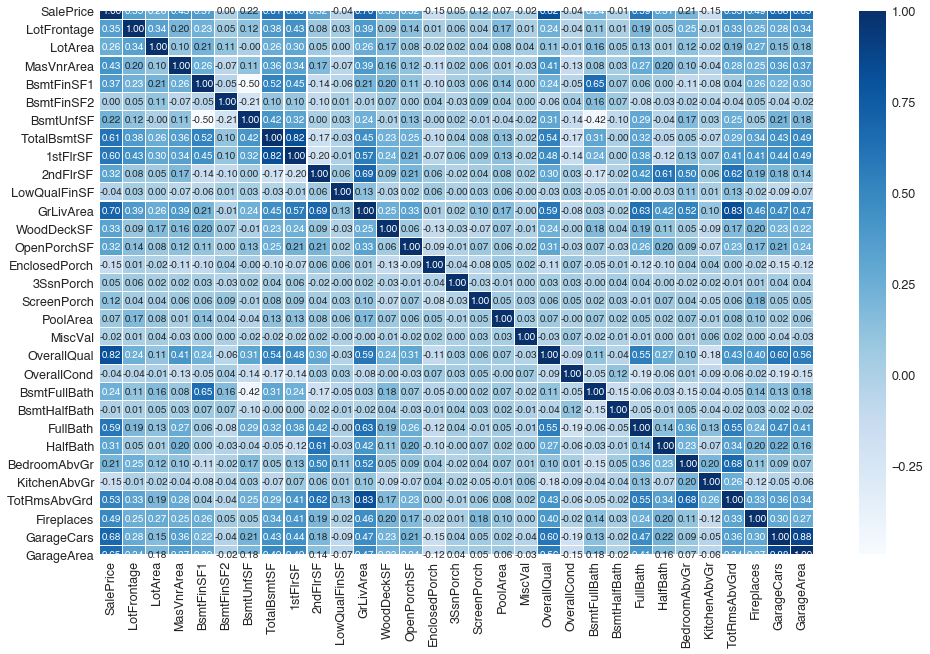

In [103]:
plt.figure(figsize=(16,10))
sns.heatmap(data = df_n.corr(), annot=True, fmt = '.2f', linewidths=.1, cmap='Blues')

In [11]:
df_n.iloc[:,1:]

LotFrontage  LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
Id                                                                          
1            65.0     8450       196.0         706           0        150   
2            80.0     9600         0.0         978           0        284   
3            68.0    11250       162.0         486           0        434   
4            60.0     9550         0.0         216           0        540   
5            84.0    14260       350.0         655           0        490   
...           ...      ...         ...         ...         ...        ...   
1456         62.0     7917         0.0           0           0        953   
1457         85.0    13175       119.0         790         163        589   
1458         66.0     9042         0.0         275           0        877   
1459         68.0     9717         0.0          49        1029          0   
1460         75.0     9937         0.0         830         290        136   

      TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  ...  BsmtFullBath  \
Id                                                   ...                 
1             856       856       854             0  ...             1   
2            1262      1262         0             0  ...             0   
3             920       920       866             0  ...             1   
4             756       961       756             0  ...             1   
5            1145      1145      1053             0  ...             1   
...           ...       ...       ...           ...  ...           ...   
1456          953       953       694             0  ...             0   
1457         1542      2073         0             0  ...             1   
1458         1152      1188      1152             0  ...             0   
1459         1078      1078         0             0  ...             1   
1460         1256      1256         0             0  ...             1   

      BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
Id                                                                   
1                0         2         1             3             1   
2                1         2         0             3             1   
3                0         2         1             3             1   
4                0         1         0             3             1   
5                0         2         1             4             1   
...            ...       ...       ...           ...           ...   
1456             0         2         1             3             1   
1457             0         2         0             3             1   
1458             0         2         0             4             1   
1459             0         1         0             2             1   
1460             0         1         1             3             1   

      TotRmsAbvGrd  Fireplaces  GarageCars  GarageArea  
Id                                                      
1                8           0           2         548  
2                6           1           2         460  
3                6           1           2         608  
4                7           1           3         642  
5                9           1           3         836  
...            ...         ...         ...         ...  
1456             7           1           2         460  
1457             7           2           2         500  
1458             9           2           1         252  
1459             5           0           1         240  
1460             6           0           1         276  

[1460 rows x 30 columns]

In [12]:
#plt.figure(figsize=(15,10))
#sns.heatmap(data = stats.zmap(df_n, df_n), annot=True, fmt = '.2f', linewidths=.1, cmap='Reds')
stats.zmap(df_n.iloc[:,0].to_numpy().reshape(-1,1), df_n.iloc[:,1:].to_numpy()).shape

(1460, 30)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a6b50d160>,
      dtype=object)

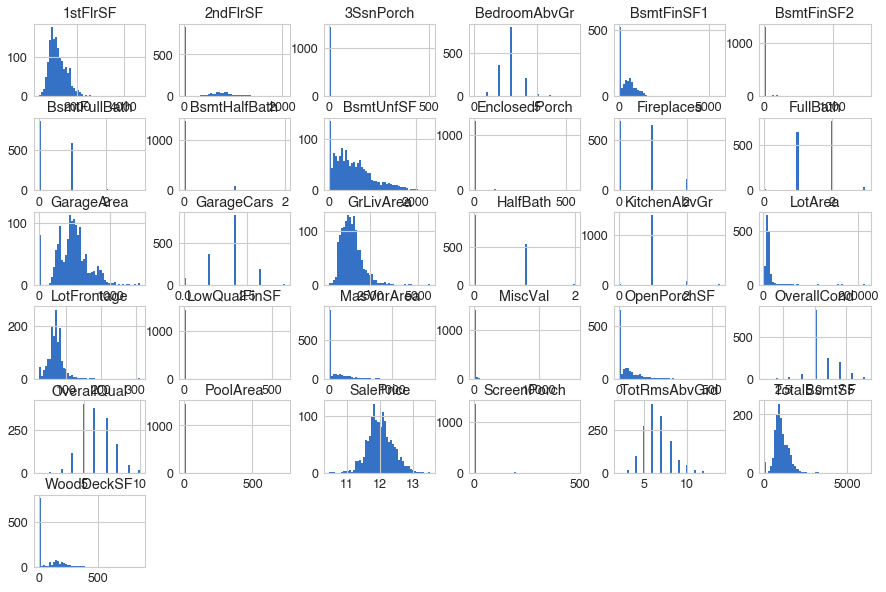

In [13]:
df_n.hist(bins=50, figsize=(15,10))

In [14]:
df.drop(df[df['LotFrontage']>300].index, axis=0, inplace=True)

In [15]:
df[df['LotFrontage']>300]

Empty DataFrame
Columns: [Neighborhood, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, GarageYrBltImputed]
Index: []

[0 rows x 81 columns]

In [16]:
df[df['LotArea']>100000]

Neighborhood  MSSubClass MSZoning  LotFrontage  LotArea Street Alley  \
Id                                                                         
250      ClearCr          50       RL         80.0   159000   Pave    NA   
314       Timber          20       RL        150.0   215245   Pave    NA   
336       Timber         190       RL         85.0   164660   Grvl    NA   
707      ClearCr          20       RL         80.0   115149   Pave    NA   

    LotShape LandContour Utilities  ... PoolQC Fence MiscFeature MiscVal  \
Id                                  ...                                    
250      IR2         Low    AllPub  ...     NA    NA        Shed     500   
314      IR3         Low    AllPub  ...     NA    NA          NA       0   
336      IR1         HLS    AllPub  ...     NA    NA        Shed     700   
707      IR2         Low    AllPub  ...     NA    NA          NA       0   

    MoSold YrSold  SaleType  SaleCondition  SalePrice  GarageYrBltImputed  
Id                                                                         
250      6   2007        WD         Normal  12.531776                   0  
314      6   2009        WD         Normal  12.834684                   0  
336      8   2008        WD         Normal  12.341263                   0  
707      6   2007        WD         Normal  12.618186                   0  

[4 rows x 81 columns]

In [17]:
df[df['BsmtFinSF1']>5000]

Empty DataFrame
Columns: [Neighborhood, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, GarageYrBltImputed]
Index: []

[0 rows x 81 columns]

In [18]:
df[df['TotalBsmtSF']>6000]

Empty DataFrame
Columns: [Neighborhood, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, GarageYrBltImputed]
Index: []

[0 rows x 81 columns]

In [19]:
df[df['1stFlrSF']>4000]

Empty DataFrame
Columns: [Neighborhood, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, GarageYrBltImputed]
Index: []

[0 rows x 81 columns]

In [20]:
df[df['GrLivArea']>4600]

Neighborhood  MSSubClass MSZoning  LotFrontage  LotArea Street Alley  \
Id                                                                         
524      Edwards          60       RL        130.0    40094   Pave    NA   

    LotShape LandContour Utilities  ... PoolQC Fence MiscFeature MiscVal  \
Id                                  ...                                    
524      IR1         Bnk    AllPub  ...     NA    NA          NA       0   

    MoSold YrSold  SaleType  SaleCondition  SalePrice  GarageYrBltImputed  
Id                                                                         
524     10   2007       New        Partial  12.126764                   0  

[1 rows x 81 columns]

In [21]:
df[(df['GarageArea']>1220) & (df['SalePrice']>1220)]

Empty DataFrame
Columns: [Neighborhood, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, GarageYrBltImputed]
Index: []

[0 rows x 81 columns]

Text(0.5, 1.0, 'LotFrontage')

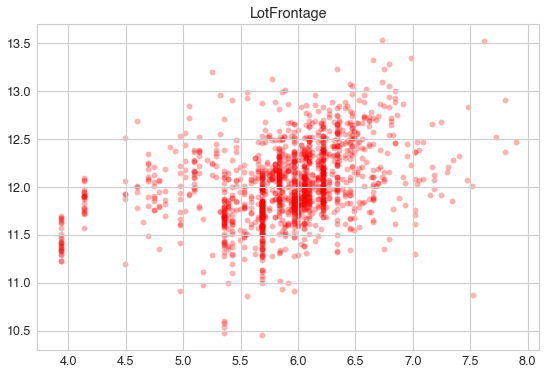

In [111]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy import stats
scaler = RobustScaler()

df_n[df_n['LotFrontage']>300].index
df_tt = df_n.drop(935,axis=0).drop(1299,axis=0)
df_tt['LotFrontage'] = special.boxcox1p(df_tt['LotFrontage'],0.15)
plt.figure(figsize=(9, 6))    
plt.scatter(df_tt['LotFrontage'],df_tt['SalePrice'], alpha='0.3', color='red', cmap='viridis')
plt.title('LotFrontage')
#sns.boxplot(df_n[i],df_n['SalePrice'])

Text(0.5, 1.0, 'LotArea')

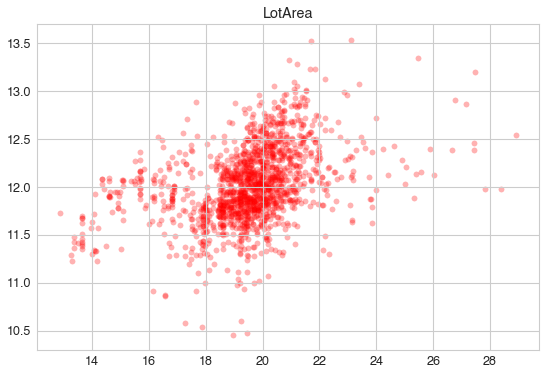

In [122]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy import stats
scaler = RobustScaler()

df_n[df_n['LotArea']>100000].index
df_tt = df_n.drop(250,axis=0).drop(314,axis=0).drop(336,axis=0).drop(707,axis=0)
df_tt['LotArea'] = special.boxcox1p(df_tt['LotArea'],0.15)
plt.figure(figsize=(9, 6))    
plt.scatter(df_tt['LotArea'],df_tt['SalePrice'], alpha='0.3', color='red', cmap='viridis')
plt.title('LotArea')
#sns.boxplot(df_n[i],df_n['SalePrice'])

/Users/necronia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


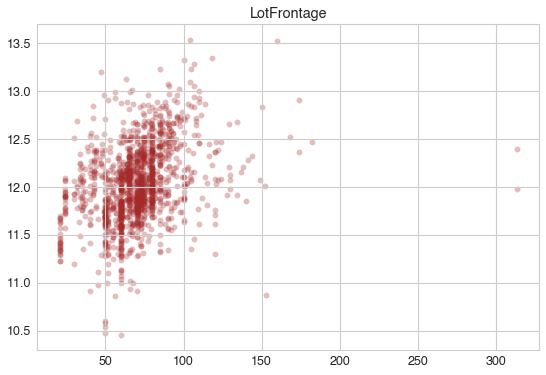

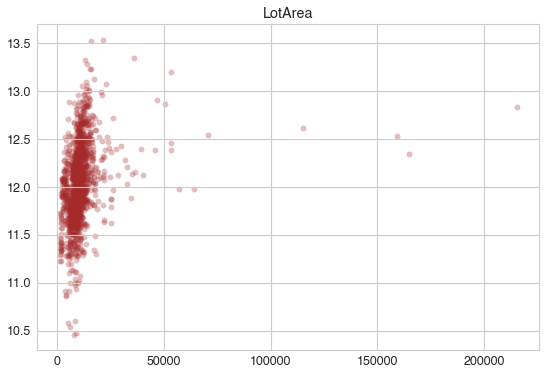

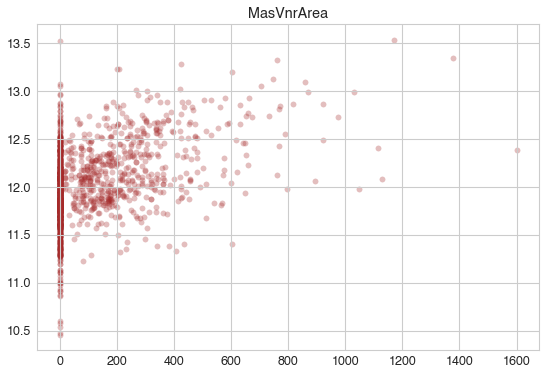

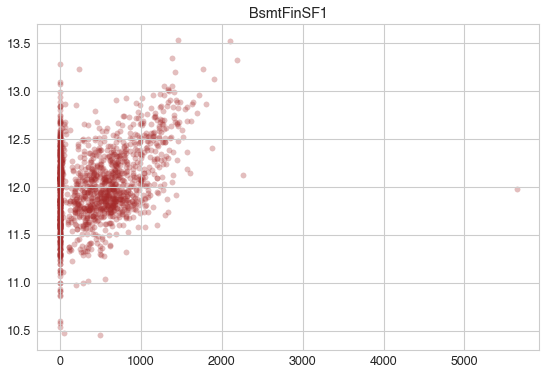

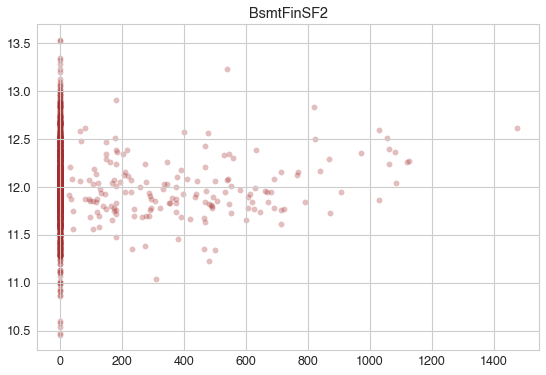

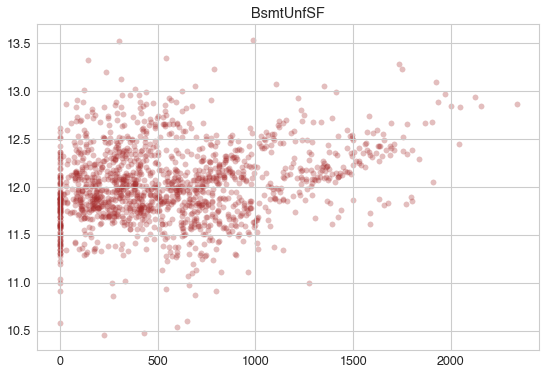

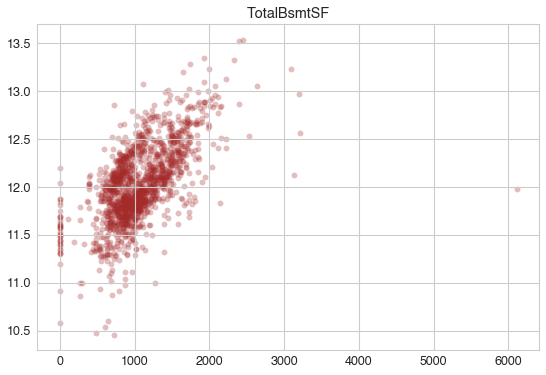

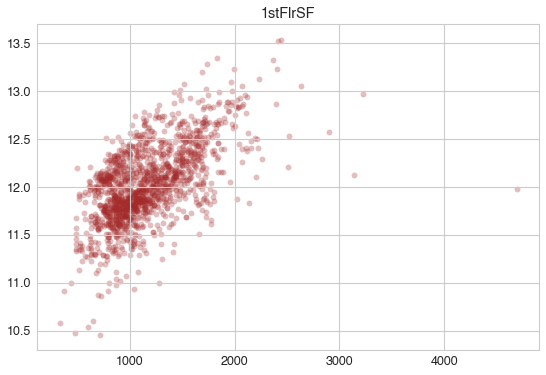

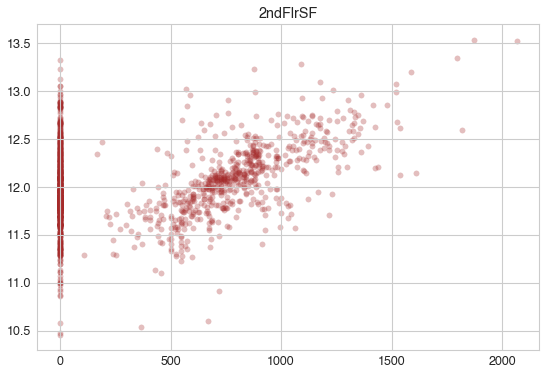

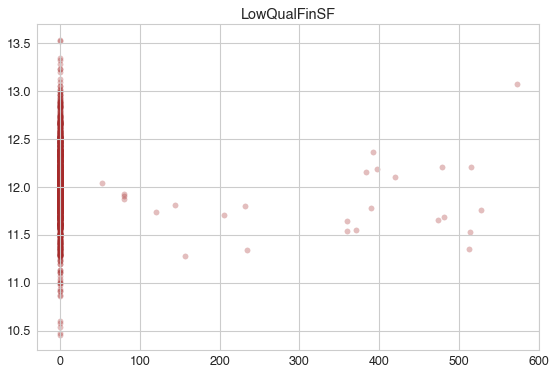

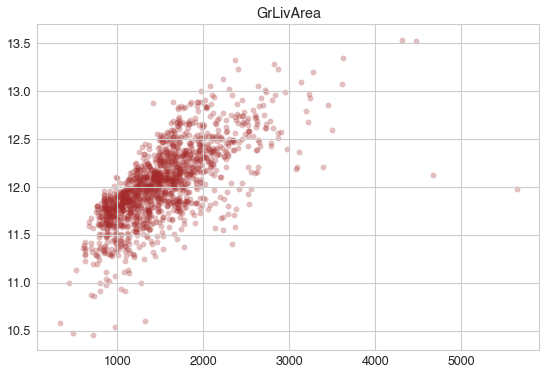

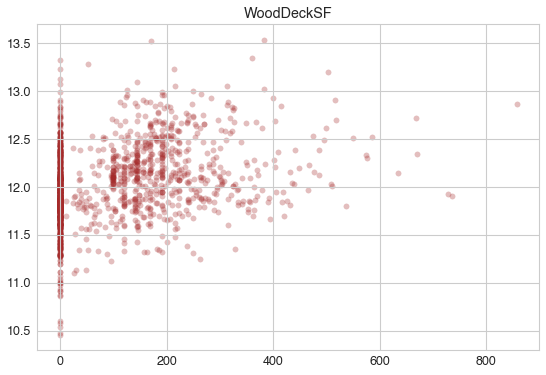

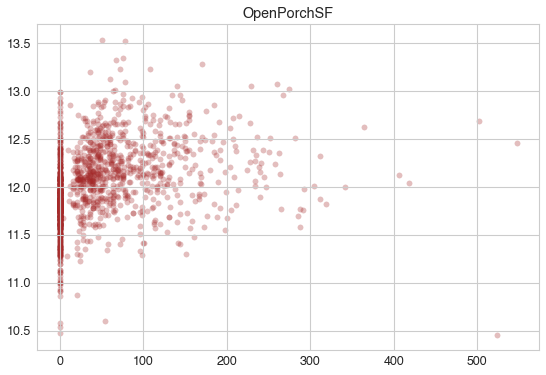

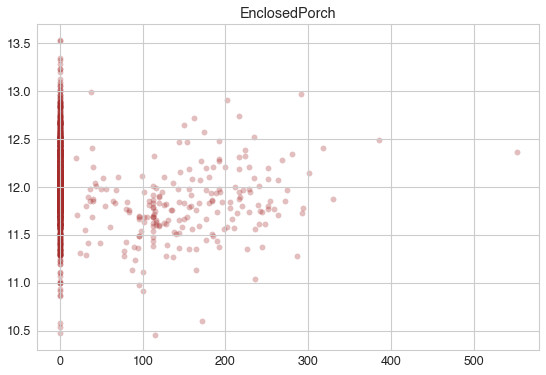

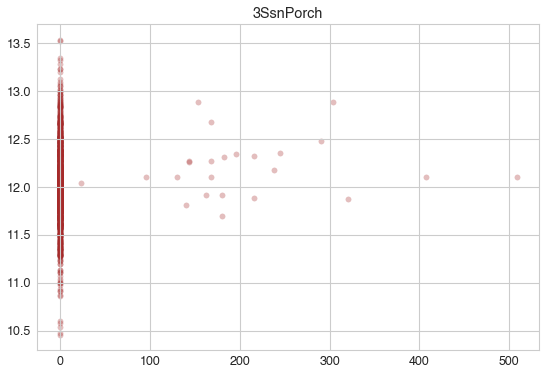

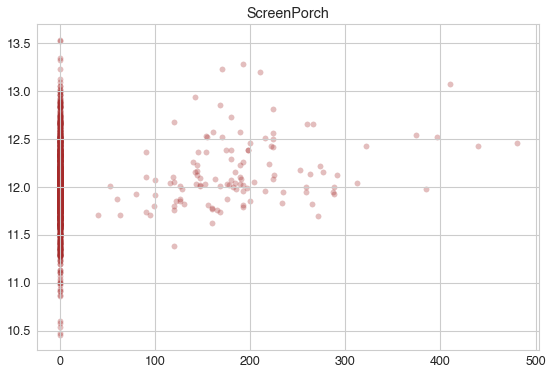

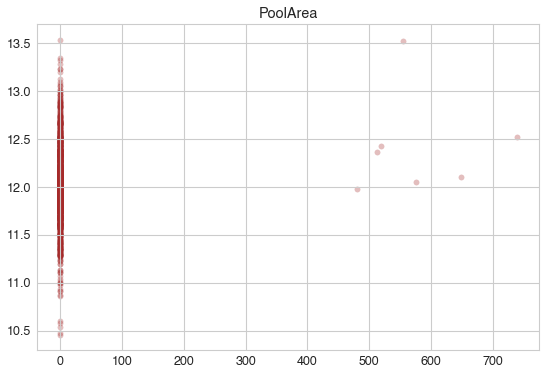

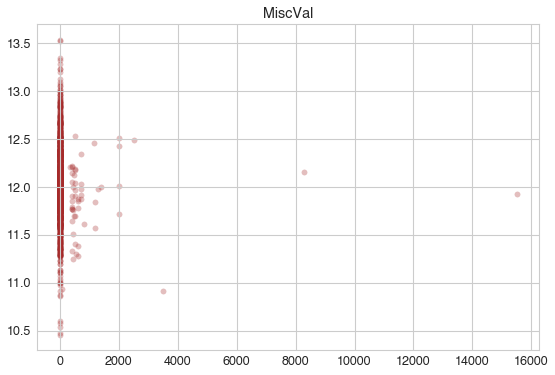

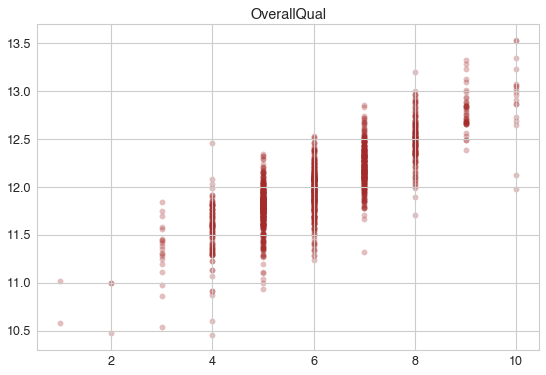

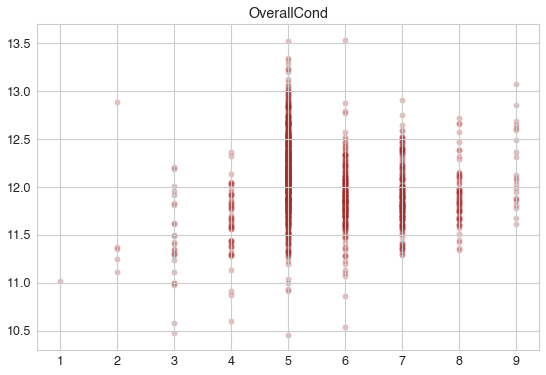

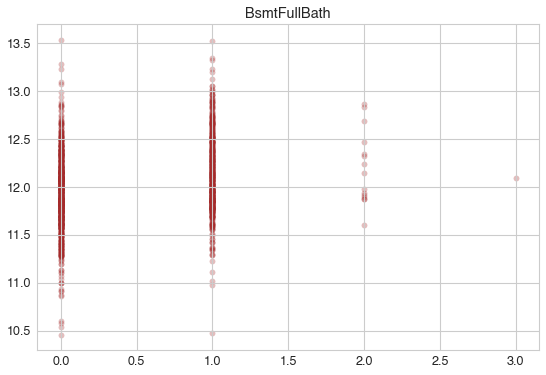

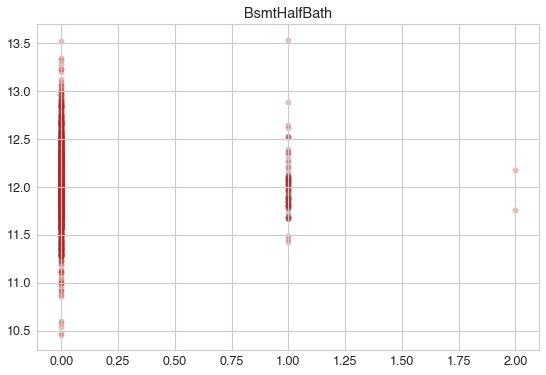

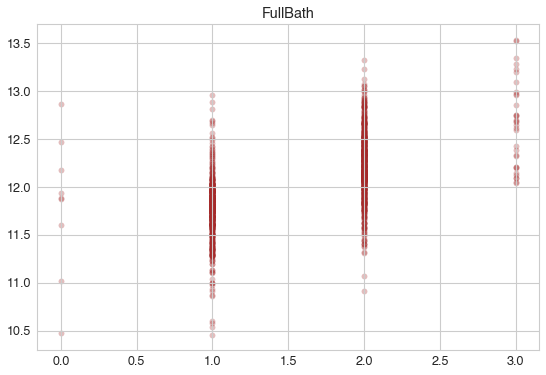

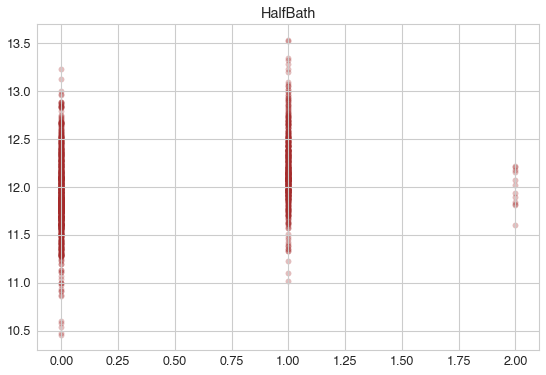

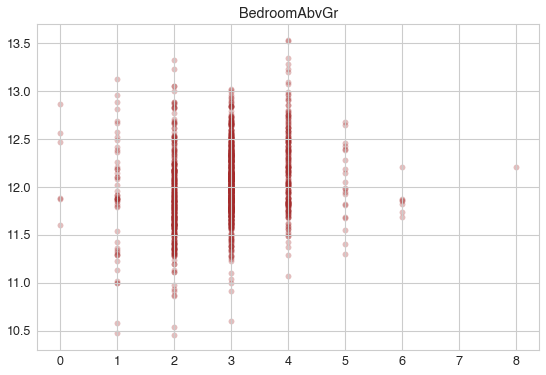

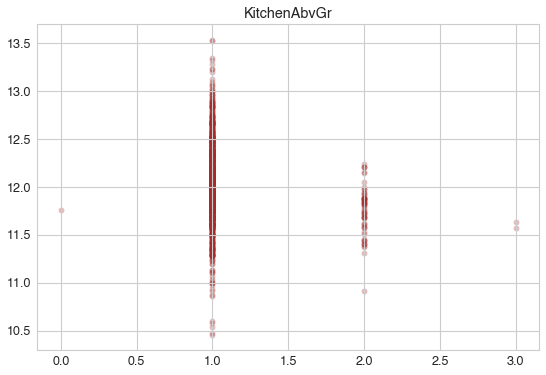

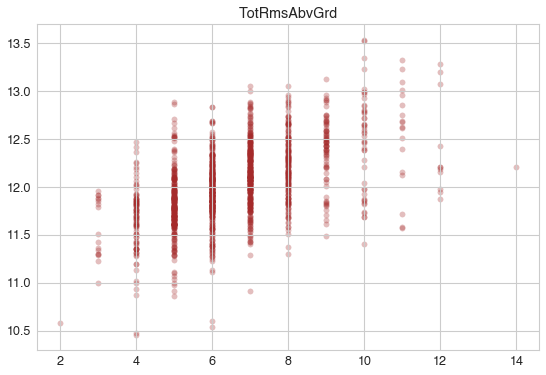

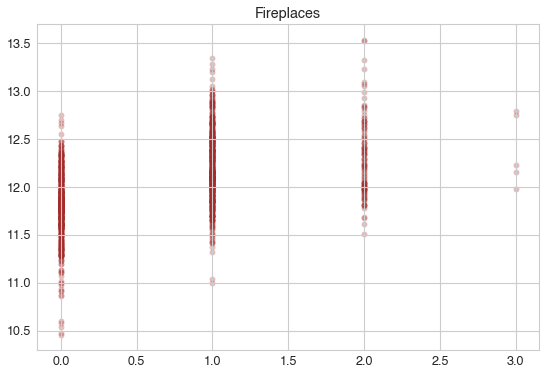

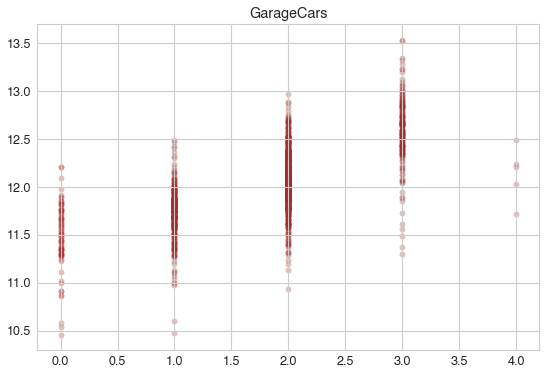

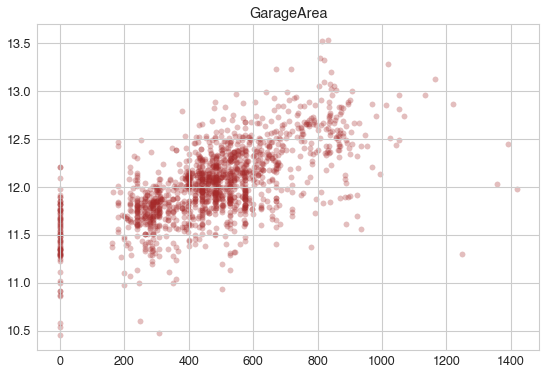

In [26]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy import stats
scaler = RobustScaler()
for i in df_n.columns[1:]:
    plt.figure(figsize=(9, 6))    
    plt.scatter(df_n[i],df_n['SalePrice'], alpha='0.3', color='brown', cmap='viridis')
    plt.title(i)
    #sns.boxplot(df_n[i],df_n['SalePrice'])

In [27]:
  [n for n in df.columns if (df[i].dtype == int) | (df[i].dtype == float)]

['Neighborhood',
 'MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'Enc

In [127]:
#check skewed data
columns = list()
for i in df.columns:
    if (df[i].dtype == int) | (df[i].dtype == float):
        columns.append(i)
skewed = [(df.columns[i],v) for i,v in enumerate(stats.skew(df.loc[:,columns])) if v>0.7]

skewed

[('Neighborhood', 1.4051660549779539),
 ('MSZoning', 12.496198510911213),
 ('LotShape', 2.682540884612632),
 ('LandContour', 0.7918119910310527),
 ('Utilities', 4.247549637960546),
 ('LotConfig', 0.9177235888663293),
 ('Condition1', 0.9520770554726103),
 ('Condition2', 0.8135037782241883),
 ('BldgType', 8.99568801535367),
 ('HouseStyle', 1.1207581291618947),
 ('OverallCond', 4.09589469134697),
 ('RoofMatl', 4.480267553258205),
 ('ExterQual', 1.5411903509987217),
 ('ExterCond', 2.3663485316878274),
 ('Foundation', 3.0839869312270727),
 ('BsmtQual', 10.28650962784407),
 ('BsmtCond', 4.114689936247838),
 ('BsmtExposure', 15.932532241700939),
 ('BsmtFinType1', 24.434913089450802),
 ('BsmtUnfSF', 3.880570000581223)]

In [29]:
# normalization
scaler = StandardScaler()
df_n_scaled = scaler.fit_transform(df_n)
df_n_scaled = pd.DataFrame(df_n_scaled, columns = df_n.columns)
df_n_scaled.head(5)

SalePrice  LotFrontage   LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  \
0   0.560067    -0.231877 -0.207142    0.514104    0.575425   -0.288653   
1   0.212763     0.437043 -0.091886   -0.570750    1.171992   -0.288653   
2   0.734046    -0.098093  0.073480    0.325915    0.092907   -0.288653   
3  -0.437383    -0.454850 -0.096897   -0.570750   -0.499274   -0.288653   
4   1.014651     0.615421  0.375148    1.366489    0.463568   -0.288653   

   BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  ...  BsmtFullBath  \
0  -0.944591    -0.459303 -0.793434  1.161852  ...      1.107810   
1  -0.641228     0.466465  0.257140 -0.795163  ...     -0.819964   
2  -0.301643    -0.313369 -0.627826  1.189351  ...      1.107810   
3  -0.061670    -0.687324 -0.521734  0.937276  ...      1.107810   
4  -0.174865     0.199680 -0.045611  1.617877  ...      1.107810   

   BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  \
0     -0.241061  0.789741  1.227585      0.163779     -0.211454      0.912210   
1      3.948809  0.789741 -0.761621      0.163779     -0.211454     -0.318683   
2     -0.241061  0.789741  1.227585      0.163779     -0.211454     -0.318683   
3     -0.241061 -1.026041 -0.761621      0.163779     -0.211454      0.296763   
4     -0.241061  0.789741  1.227585      1.390023     -0.211454      1.527656   

   Fireplaces  GarageCars  GarageArea  
0   -0.951226    0.311725    0.351000  
1    0.600495    0.311725   -0.060731  
2    0.600495    0.311725    0.631726  
3    0.600495    1.650307    0.790804  
4    0.600495    1.650307    1.698485  

[5 rows x 31 columns]

In [30]:
# log transformation
df_n_scaled_log = np.log1p(df_n)
df_o_scaled_log = np.log1p(df_o)
df_n_scaled_log.head(5)

SalePrice  LotFrontage   LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  \
Id                                                                         
1    2.583824     4.189655  9.042040    5.283204    6.561031         0.0   
2    2.573300     4.394449  9.169623    0.000000    6.886532         0.0   
3    2.589054     4.234107  9.328212    5.093750    6.188264         0.0   
4    2.553297     4.110874  9.164401    0.000000    5.379897         0.0   
5    2.597433     4.442651  9.565284    5.860786    6.486161         0.0   

    BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  ...  BsmtFullBath  \
Id                                              ...                 
1    5.017280     6.753438  6.753438  6.751101  ...      0.693147   
2    5.652489     7.141245  7.141245  0.000000  ...      0.000000   
3    6.075346     6.825460  6.825460  6.765039  ...      0.693147   
4    6.293419     6.629363  6.869014  6.629363  ...      0.693147   
5    6.196444     7.044033  7.044033  6.960348  ...      0.693147   

    BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
Id                                                                 
1       0.000000  1.098612  0.693147      1.386294      0.693147   
2       0.693147  1.098612  0.000000      1.386294      0.693147   
3       0.000000  1.098612  0.693147      1.386294      0.693147   
4       0.000000  0.693147  0.000000      1.386294      0.693147   
5       0.000000  1.098612  0.693147      1.609438      0.693147   

    TotRmsAbvGrd  Fireplaces  GarageCars  GarageArea  
Id                                                    
1       2.197225    0.000000    1.098612    6.308098  
2       1.945910    0.693147    1.098612    6.133398  
3       1.945910    0.693147    1.098612    6.411818  
4       2.079442    0.693147    1.386294    6.466145  
5       2.302585    0.693147    1.386294    6.729824  

[5 rows x 31 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a6cc2f6d8>,
      dtype=object)

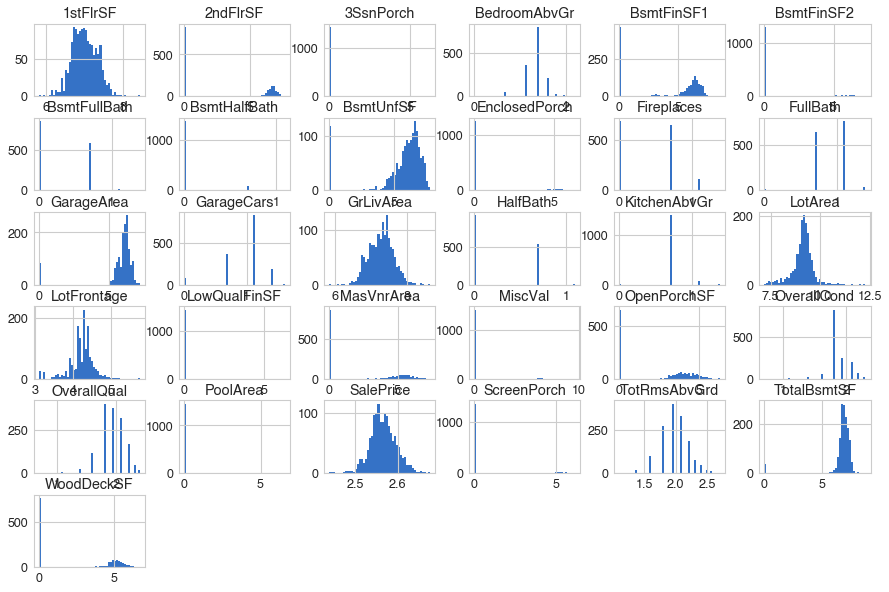

In [31]:
df_n_scaled_log.hist(bins=50, figsize=(15,10))

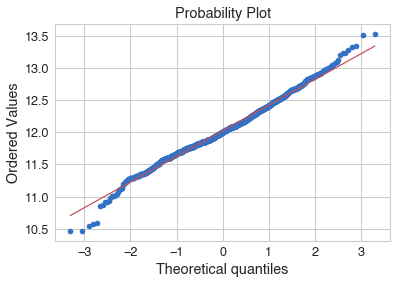

In [126]:
stats.probplot(df.SalePrice, dist="norm", plot=pylab)
pylab.show()

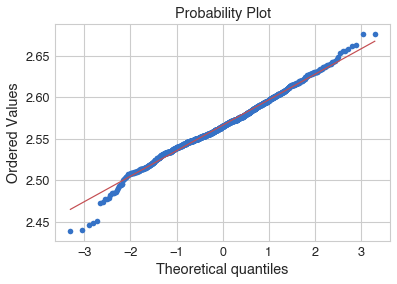

In [32]:
stats.probplot(df_n_scaled_log.SalePrice, dist="norm", plot=pylab)
pylab.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a398f7a20>,
      dtype=object)

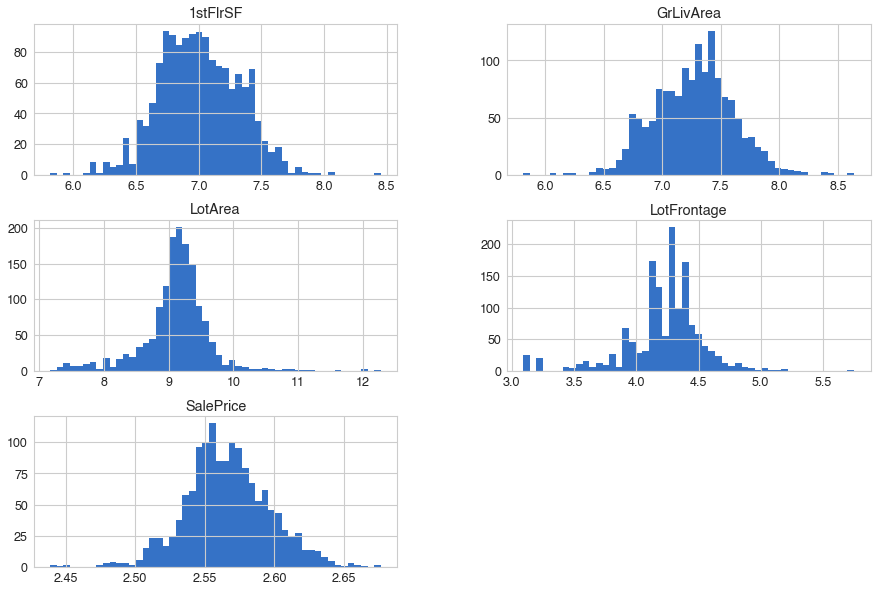

In [33]:
df_o_scaled_log.hist(bins=50, figsize=(15,10))

In [34]:
# box-cox transformation
#from scipy.special import boxcox1p
df_n_scaled_bc = pd.DataFrame()
for i in df_n.columns:
    #df_3_n_scaled_bc[i] = boxcox1p(df_3_o[i],0.3)
    df_n_scaled_bc[i] = special.boxcox1p(df_n[i], 0.15)
df_n_scaled_bc

SalePrice  LotFrontage    LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  \
Id                                                                            
1      3.156009     5.831328  19.212182    8.059126   11.170327    0.000000   
2      3.140516     6.221214  19.712205    0.000000   12.062832    0.000000   
3      3.163719     5.914940  20.347241    7.646538   10.200343    0.000000   
4      3.111134     5.684507  19.691553    0.000000    8.274266    0.000000   
5      3.176081     6.314735  21.325160    9.391827   10.971129    0.000000   
...         ...          ...        ...         ...         ...         ...   
1456   3.136418     5.744420  18.960528    0.000000    0.000000    0.000000   
1457   3.156806     6.337529  20.994868    7.003881   11.473247    7.659675   
1458   3.183094     5.859551  19.476345    0.000000    8.823108    0.000000   
1459   3.112853     5.914940  19.760176    0.000000    5.321541   12.206046   
1460   3.117081     6.098626  19.849063    0.000000   11.607976    8.946561   

      BsmtUnfSF  TotalBsmtSF   1stFlrSF   2ndFlrSF  ...  BsmtFullBath  \
Id                                                  ...                 
1      7.483296    11.692623  11.692623  11.686189  ...      0.730463   
2      8.897844    12.792276  12.792276   0.000000  ...      0.000000   
3      9.917060    11.892039  11.892039  11.724598  ...      0.730463   
4     10.468500    11.354094  12.013683  11.354094  ...      0.730463   
5     10.221051    12.510588  12.510588  12.271365  ...      0.730463   
...         ...          ...        ...        ...  ...           ...   
1456  11.990298    11.990298  11.990298  11.124583  ...      0.000000   
1457  10.692807    13.385607  14.295205   0.000000  ...      0.730463   
1458  11.759412    12.528113  12.616840  12.528113  ...      0.000000   
1459   0.000000    12.338074  12.338074   0.000000  ...      0.730463   
1460   7.278279    12.778382  12.778382   0.000000  ...      0.730463   

      BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
Id                                                                   
1         0.000000  1.194318  0.730463      1.540963      0.730463   
2         0.730463  1.194318  0.000000      1.540963      0.730463   
3         0.000000  1.194318  0.730463      1.540963      0.730463   
4         0.000000  0.730463  0.000000      1.540963      0.730463   
5         0.000000  1.194318  0.730463      1.820334      0.730463   
...            ...       ...       ...           ...           ...   
1456      0.000000  1.194318  0.730463      1.540963      0.730463   
1457      0.000000  1.194318  0.000000      1.540963      0.730463   
1458      0.000000  1.194318  0.000000      1.820334      0.730463   
1459      0.000000  0.730463  0.000000      1.194318      0.730463   
1460      0.000000  0.730463  0.730463      1.540963      0.730463   

      TotRmsAbvGrd  Fireplaces  GarageCars  GarageArea  
Id                                                      
1         2.602594    0.000000    1.194318   10.506271  
2         2.259674    0.730463    1.194318   10.062098  
3         2.259674    0.730463    1.194318   10.775536  
4         2.440268    0.730463    1.540963   10.918253  
5         2.750250    0.730463    1.540963   11.627708  
...            ...         ...         ...         ...  
1456      2.440268    0.730463    1.194318   10.062098  
1457      2.440268    1.194318    1.194318   10.272202  
1458      2.750250    1.194318    0.730463    8.622254  
1459      2.055642    0.000000    0.730463    8.511220  
1460      2.259674    0.000000    0.730463    8.831514  

[1460 rows x 31 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a6c440d30>,
      dtype=object)

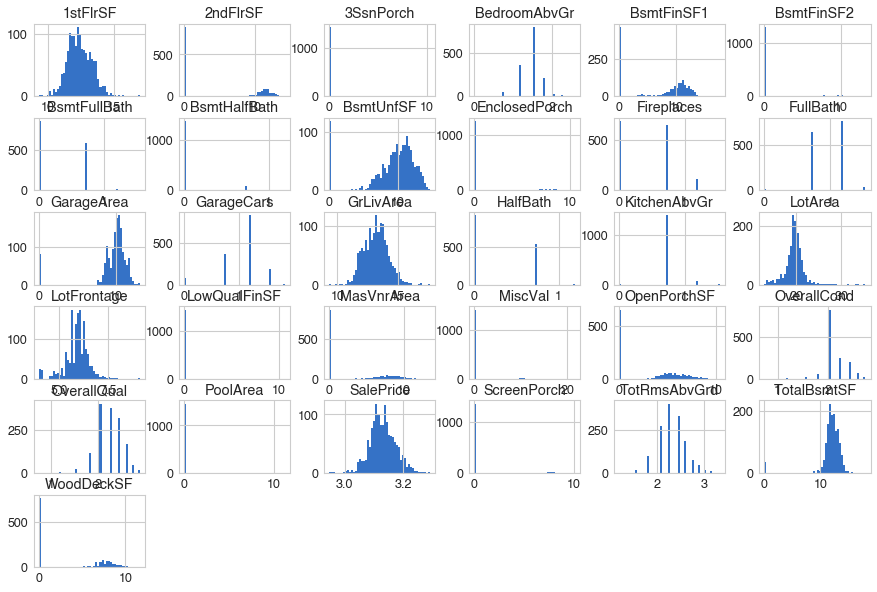

In [35]:
df_n_scaled_bc.hist(bins=50, figsize=(15,10))

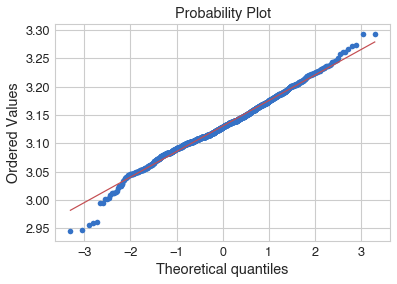

In [37]:
stats.probplot(df_n_scaled_bc.SalePrice, dist="norm", plot=pylab)
pylab.show()

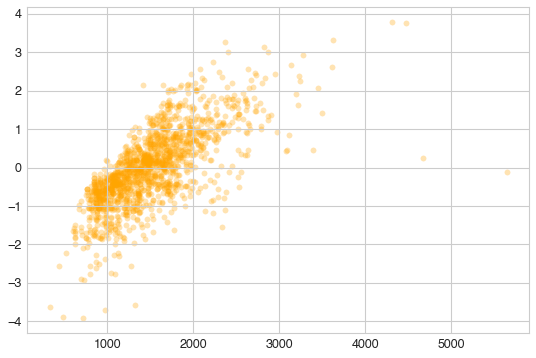

In [38]:
plt.figure(figsize=(9, 6))
plt.scatter(df_n['GrLivArea'],df_n_scaled['SalePrice'], alpha='0.3', color='orange', cmap='viridis')
#plt.scatter(df_3_n['GrLivArea'],df_3_n['SalePrice'], alpha='0.3', color='orange', cmap='viridis')

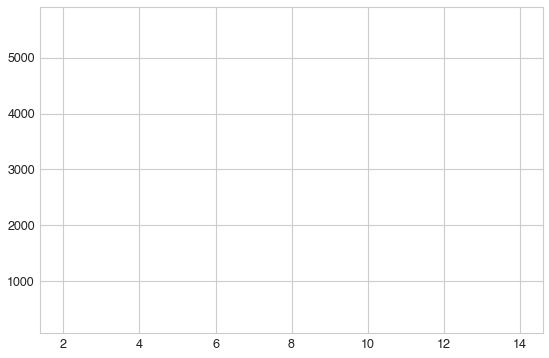

In [39]:
plt.figure(figsize=(9, 6))
plt.scatter(df_n['TotRmsAbvGrd'], df_n['GrLivArea'], alpha='0.3', color='white', cmap='viridis')

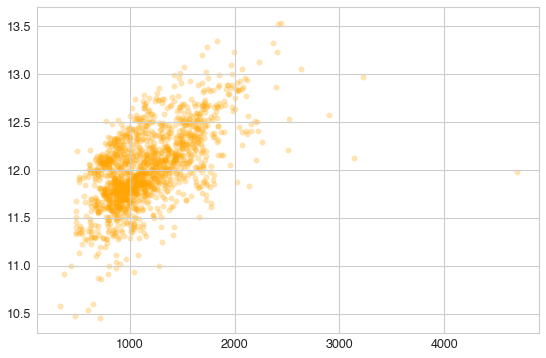

In [40]:
plt.figure(figsize=(9, 6))
plt.scatter(df_n['1stFlrSF'],df_n['SalePrice'], alpha='0.3', color='orange', cmap='viridis')

/Users/necronia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


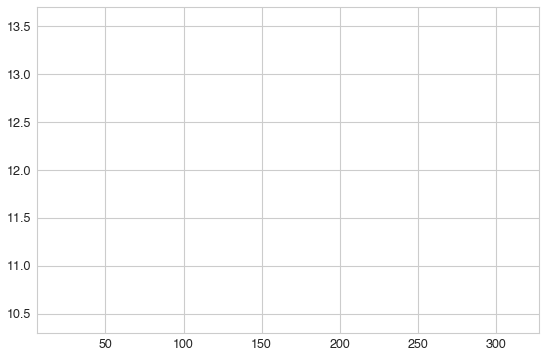

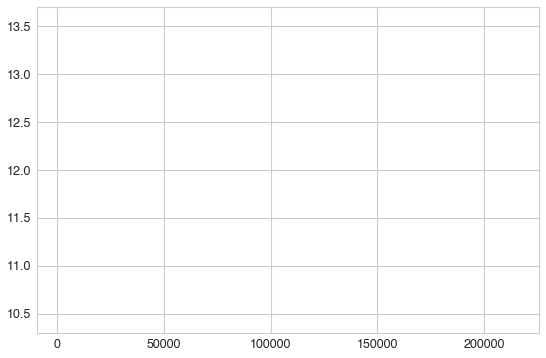

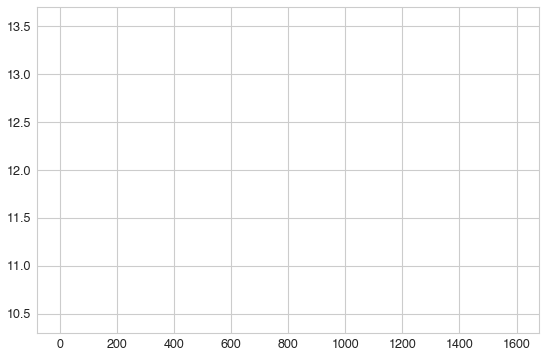

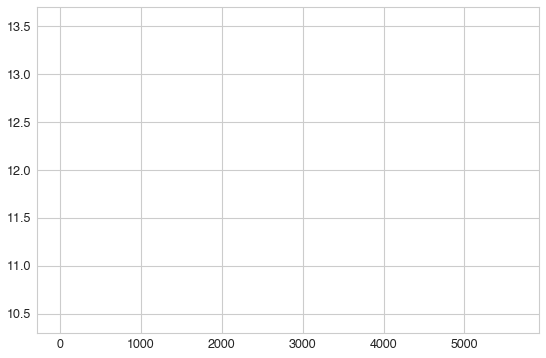

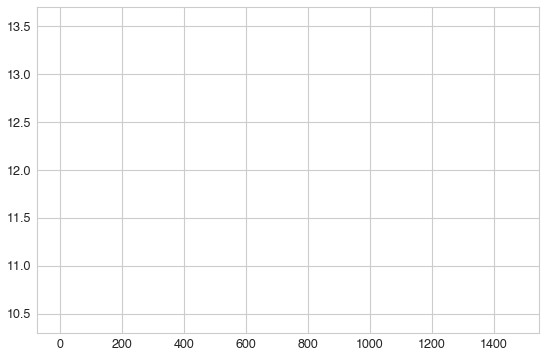

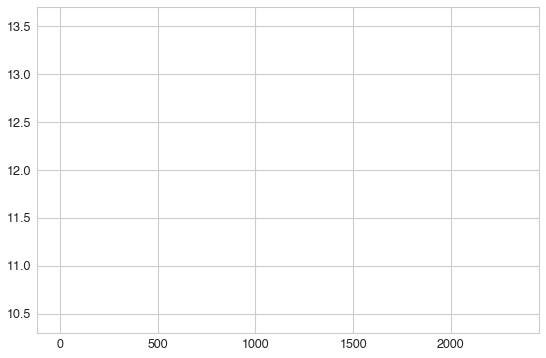

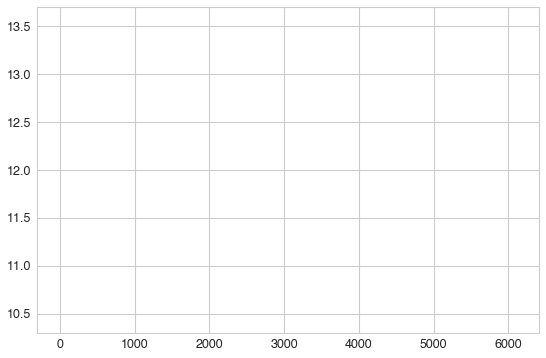

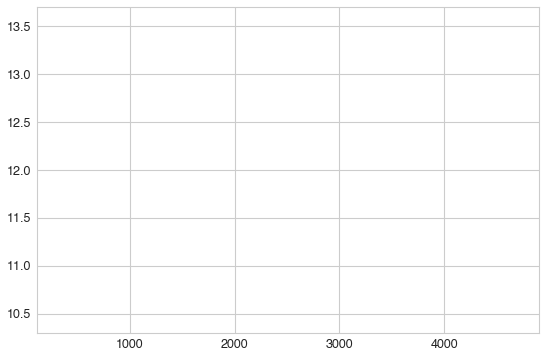

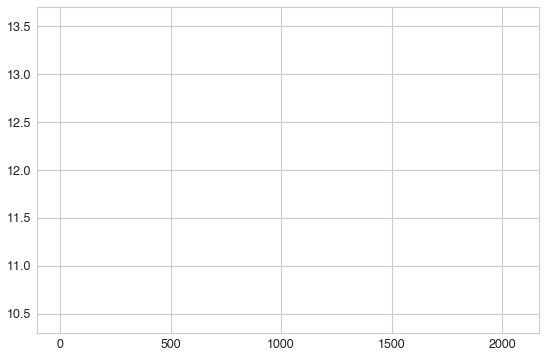

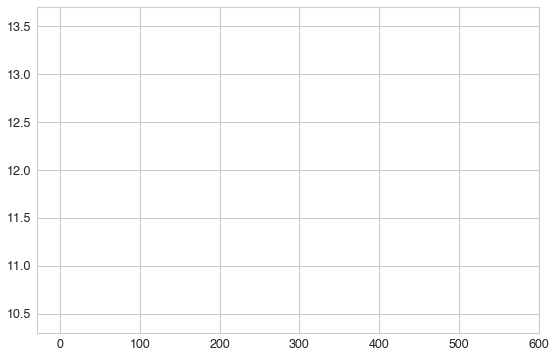

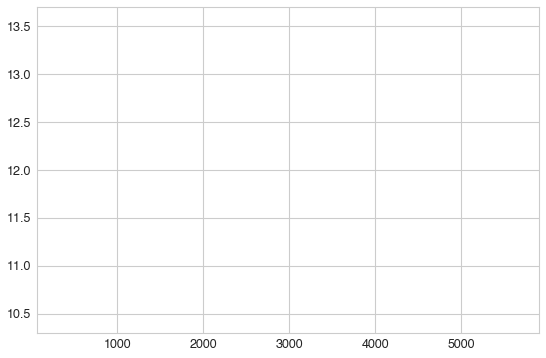

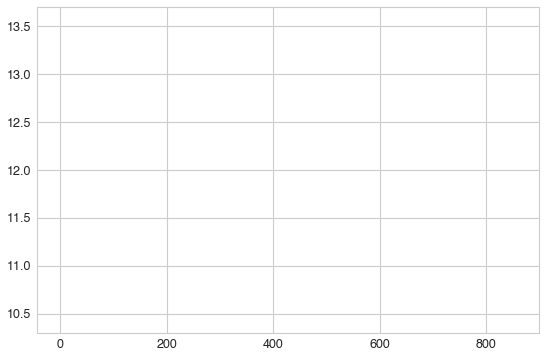

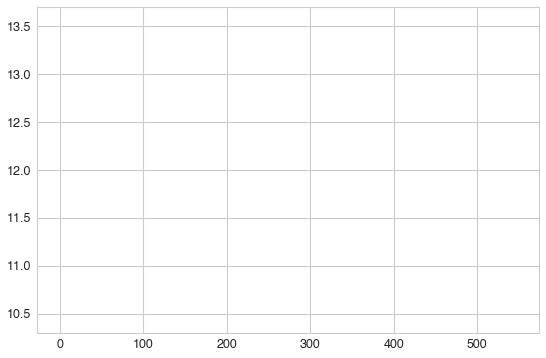

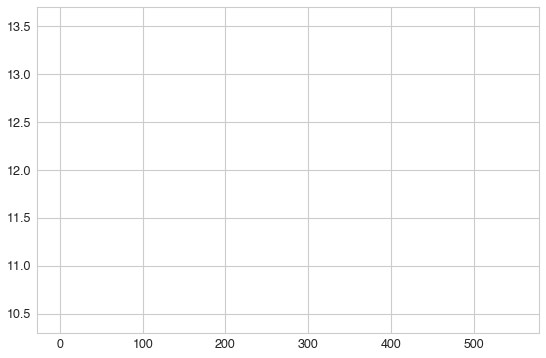

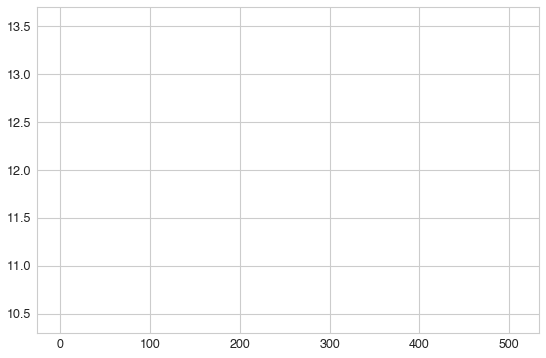

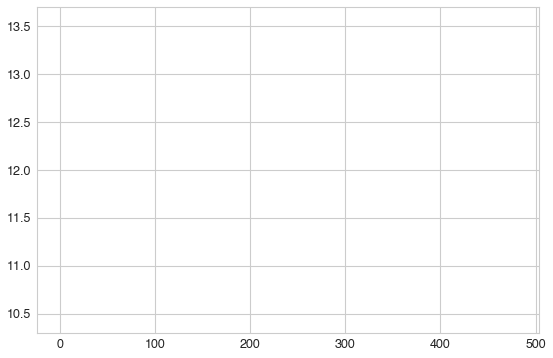

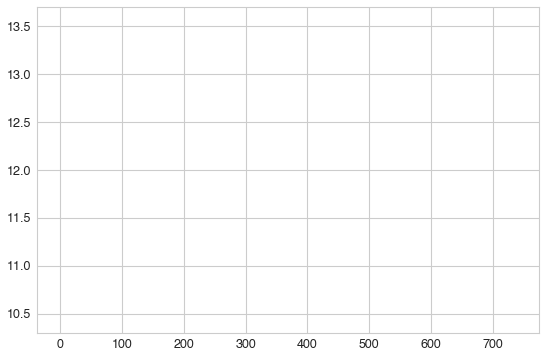

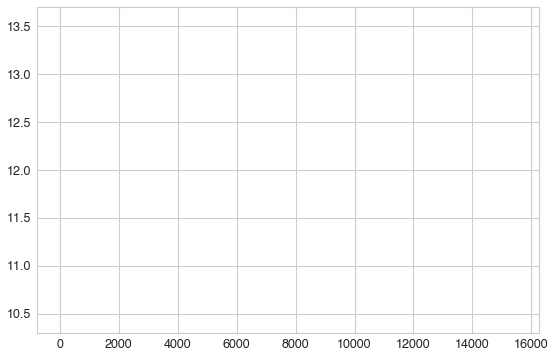

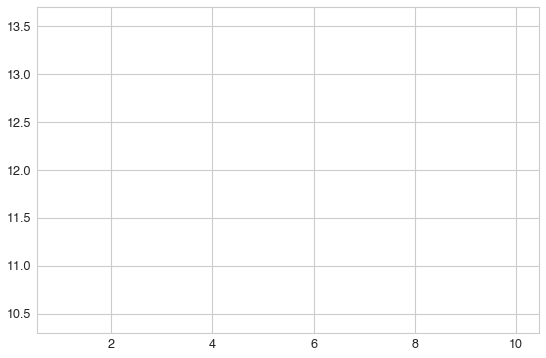

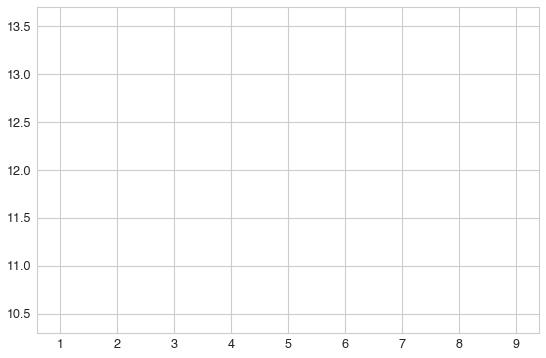

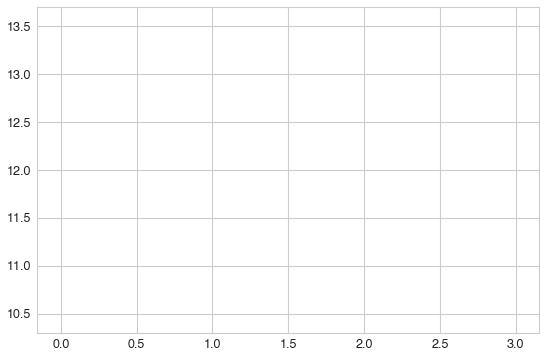

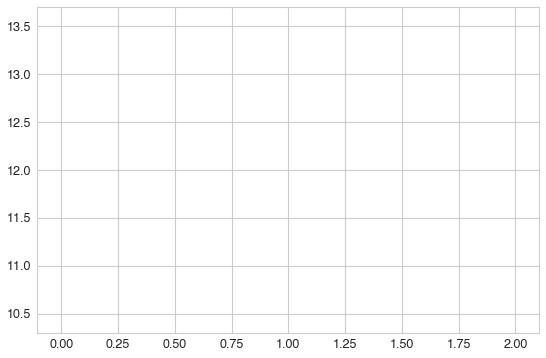

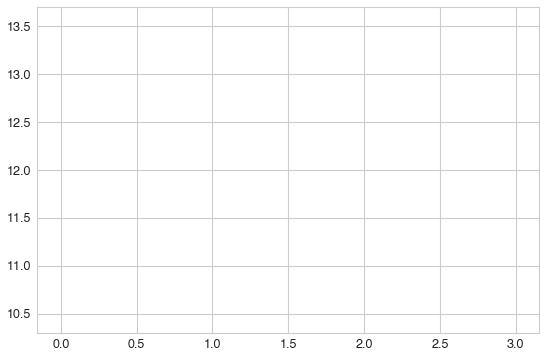

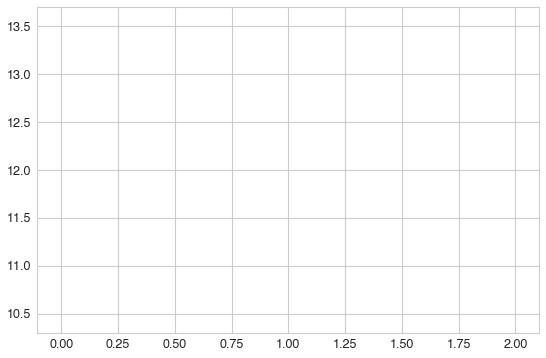

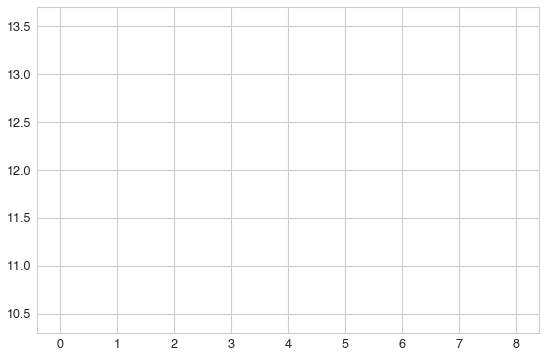

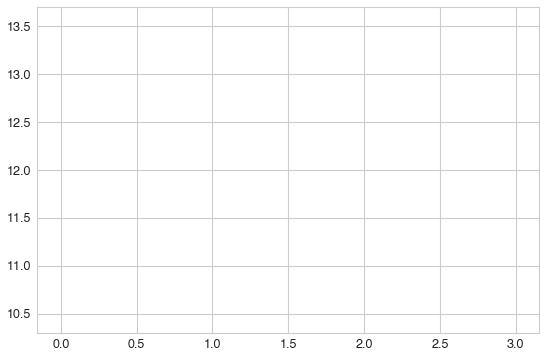

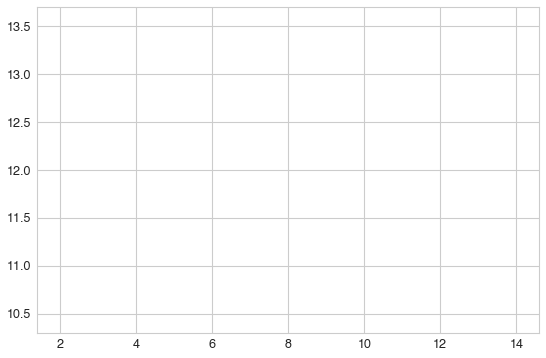

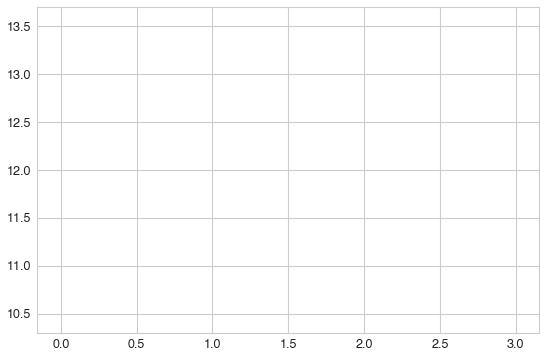

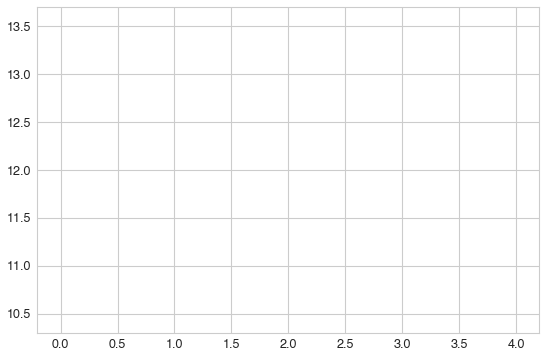

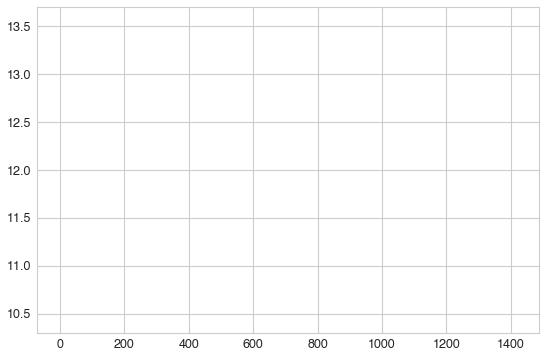

In [41]:
for i in df_n.columns[1:]:
    plt.figure(figsize=(9, 6))
    plt.scatter(df_n[i],df_n['SalePrice'], alpha='0.3', color='white', cmap='viridis')
    #sns.boxplot(df_n[i],df_n['SalePrice'])


In [42]:
en = ElasticNet(l1_ratio = 0.5, normalize=False)
alphas = np.linspace(0.1,1.1,20)
coefs_en = []

for alpha in alphas:
    en.set_params(alpha=alpha)
    en.fit(df_n_scaled_log.iloc[:,1:],df_n_scaled_log['SalePrice'])  
    coefs_en.append(en.coef_)

coefs_en = pd.DataFrame(coefs_en, index = alphas, columns = df_n_scaled_log.iloc[:,1:].columns)  
coefs_en

LotFrontage  LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
0.100000          0.0      0.0         0.0         0.0        -0.0        0.0   
0.152632          0.0      0.0         0.0         0.0        -0.0        0.0   
0.205263          0.0      0.0         0.0         0.0        -0.0        0.0   
0.257895          0.0      0.0         0.0         0.0        -0.0        0.0   
0.310526          0.0      0.0         0.0         0.0        -0.0        0.0   
0.363158          0.0      0.0         0.0         0.0        -0.0        0.0   
0.415789          0.0      0.0         0.0         0.0        -0.0        0.0   
0.468421          0.0      0.0         0.0         0.0        -0.0        0.0   
0.521053          0.0      0.0         0.0         0.0        -0.0        0.0   
0.573684          0.0      0.0         0.0         0.0        -0.0        0.0   
0.626316          0.0      0.0         0.0         0.0        -0.0        0.0   
0.678947          0.0      0.0         0.0         0.0        -0.0        0.0   
0.731579          0.0      0.0         0.0         0.0        -0.0        0.0   
0.784211          0.0      0.0         0.0         0.0        -0.0        0.0   
0.836842          0.0      0.0         0.0         0.0        -0.0        0.0   
0.889474          0.0      0.0         0.0         0.0        -0.0        0.0   
0.942105          0.0      0.0         0.0         0.0        -0.0        0.0   
0.994737          0.0      0.0         0.0         0.0        -0.0        0.0   
1.047368          0.0      0.0         0.0         0.0        -0.0        0.0   
1.100000          0.0      0.0         0.0         0.0        -0.0        0.0   

          TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  ...  BsmtFullBath  \
0.100000          0.0       0.0       0.0          -0.0  ...           0.0   
0.152632          0.0       0.0       0.0          -0.0  ...           0.0   
0.205263          0.0       0.0       0.0          -0.0  ...           0.0   
0.257895          0.0       0.0       0.0          -0.0  ...           0.0   
0.310526          0.0       0.0       0.0          -0.0  ...           0.0   
0.363158          0.0       0.0       0.0          -0.0  ...           0.0   
0.415789          0.0       0.0       0.0          -0.0  ...           0.0   
0.468421          0.0       0.0       0.0          -0.0  ...           0.0   
0.521053          0.0       0.0       0.0          -0.0  ...           0.0   
0.573684          0.0       0.0       0.0          -0.0  ...           0.0   
0.626316          0.0       0.0       0.0          -0.0  ...           0.0   
0.678947          0.0       0.0       0.0          -0.0  ...           0.0   
0.731579          0.0       0.0       0.0          -0.0  ...           0.0   
0.784211          0.0       0.0       0.0          -0.0  ...           0.0   
0.836842          0.0       0.0       0.0          -0.0  ...           0.0   
0.889474          0.0       0.0       0.0          -0.0  ...           0.0   
0.942105          0.0       0.0       0.0          -0.0  ...           0.0   
0.994737          0.0       0.0       0.0          -0.0  ...           0.0   
1.047368          0.0       0.0       0.0          -0.0  ...           0.0   
1.100000          0.0       0.0       0.0          -0.0  ...           0.0   

          BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0.100000          -0.0       0.0       0.0           0.0          -0.0   
0.152632          -0.0       0.0       0.0           0.0          -0.0   
0.205263          -0.0       0.0       0.0           0.0          -0.0   
0.257895          -0.0       0.0       0.0           0.0          -0.0   
0.310526          -0.0       0.0       0.0           0.0          -0.0   
0.363158          -0.0       0.0       0.0           0.0          -0.0   
0.415789          -0.0       0.0       0.0           0.0          -0.0   
0.468421          -0.0       0.0       0.0           0.0          -0.0   
0.5

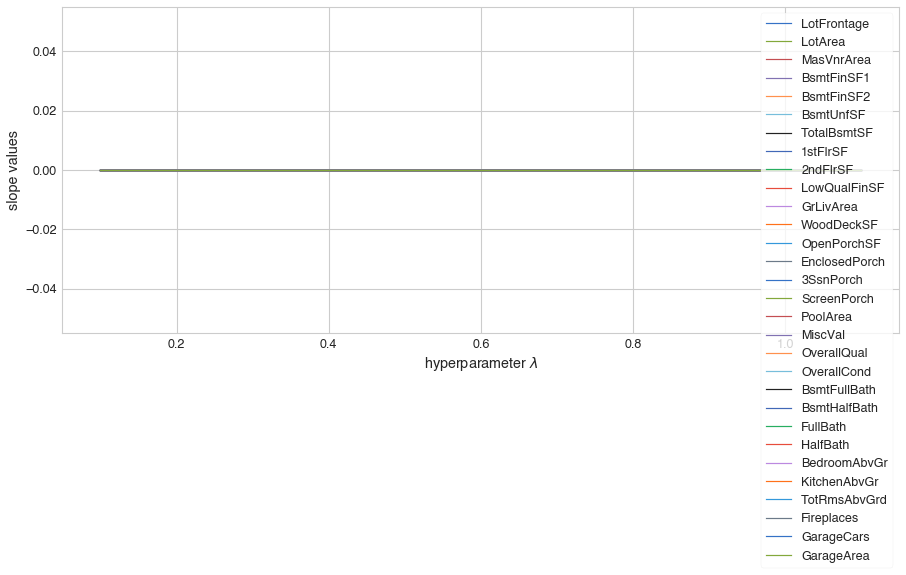

In [43]:
plt.figure(figsize=(15, 6))
for name in coefs_en.columns:
    plt.plot(coefs_en.index, coefs_en[name], label=name)
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'slope values')
plt.legend(loc=1)   

In [44]:
#feature selection
fs.VarianceThreshold(threshold = 1).fit_transform(df_n)

array([[6.500e+01, 8.450e+03, 1.960e+02, ..., 5.000e+00, 8.000e+00,
        5.480e+02],
       [8.000e+01, 9.600e+03, 0.000e+00, ..., 8.000e+00, 6.000e+00,
        4.600e+02],
       [6.800e+01, 1.125e+04, 1.620e+02, ..., 5.000e+00, 6.000e+00,
        6.080e+02],
       ...,
       [6.600e+01, 9.042e+03, 0.000e+00, ..., 9.000e+00, 9.000e+00,
        2.520e+02],
       [6.800e+01, 9.717e+03, 0.000e+00, ..., 6.000e+00, 5.000e+00,
        2.400e+02],
       [7.500e+01, 9.937e+03, 0.000e+00, ..., 6.000e+00, 6.000e+00,
        2.760e+02]])

In [45]:
# categorical variables
list(map(lambda x: df_c[x].value_counts(), df_c.columns[1:]))

[NAmes      225
 CollgCr    150
 OldTown    113
 Edwards    100
 Somerst     86
 Gilbert     79
 NridgHt     77
 Sawyer      74
 NWAmes      73
 SawyerW     59
 BrkSide     58
 Crawfor     51
 Mitchel     49
 NoRidge     41
 Timber      38
 IDOTRR      37
 ClearCr     28
 StoneBr     25
 SWISU       25
 Blmngtn     17
 MeadowV     17
 BrDale      16
 Veenker     11
 NPkVill      9
 Blueste      2
 Name: Neighborhood, dtype: int64, 20     536
 60     299
 50     144
 120     87
 30      69
 160     63
 70      60
 80      58
 90      52
 190     30
 85      20
 75      16
 45      12
 180     10
 40       4
 Name: MSSubClass, dtype: int64, RL         1151
 RM          218
 FV           65
 RH           16
 C (all)      10
 Name: MSZoning, dtype: int64, Pave    1454
 Grvl       6
 Name: Street, dtype: int64, NA      1369
 Grvl      50
 Pave      41
 Name: Alley, dtype: int64, Reg    925
 IR1    484
 IR2     41
 IR3     10
 Name: LotShape, dtype: int64, Lvl    1311
 Bnk      63
 HLS      

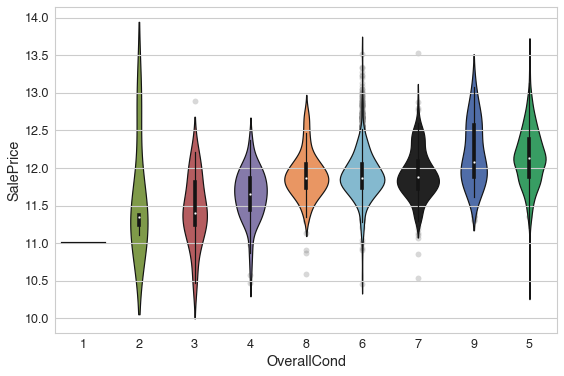

In [99]:
plt.figure(figsize=(9, 6))
order = df.groupby('OverallCond')['SalePrice'].median().sort_values()
plt.scatter(df['OverallCond'],df['SalePrice'], alpha='0.3', color='grey', cmap='viridis')
sns.violinplot(df['OverallCond'],df['SalePrice'],order=order.index)

/Users/necronia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


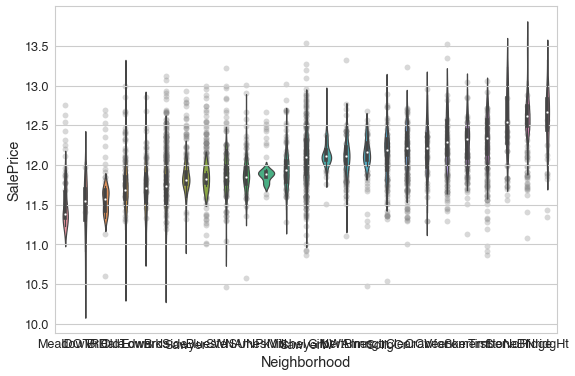

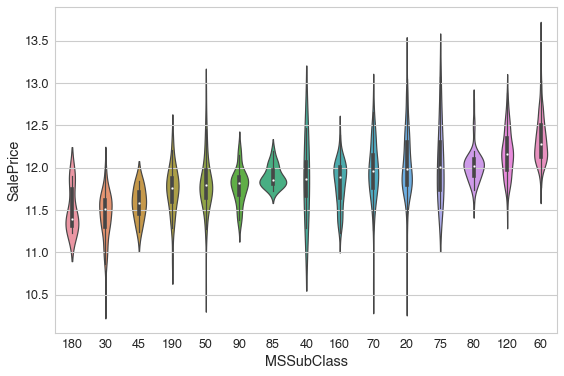

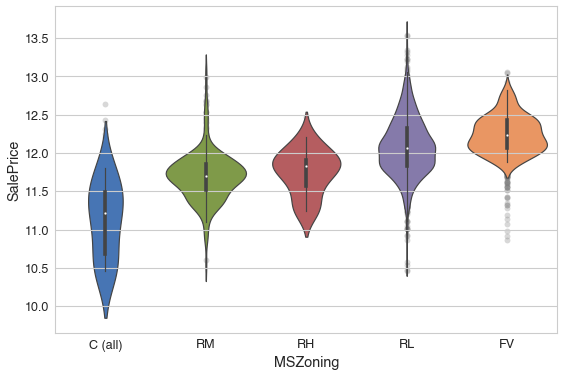

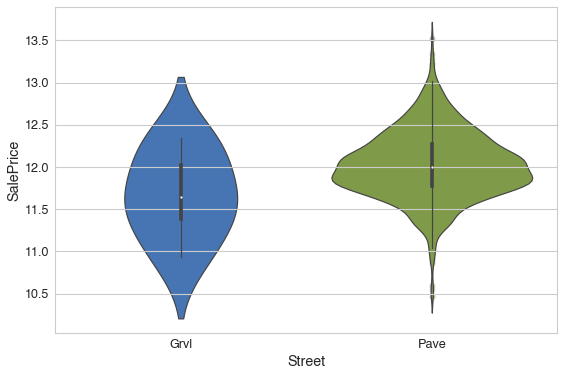

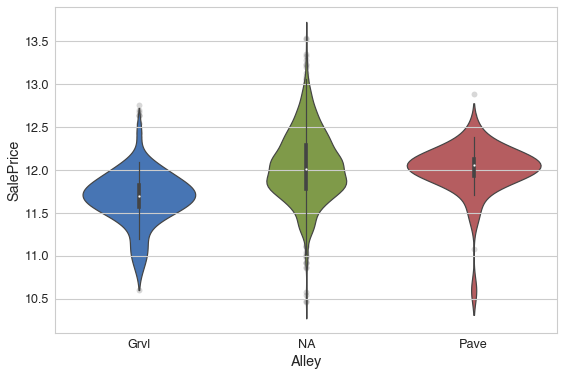

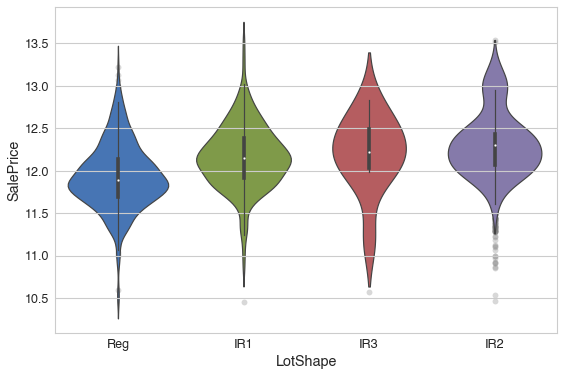

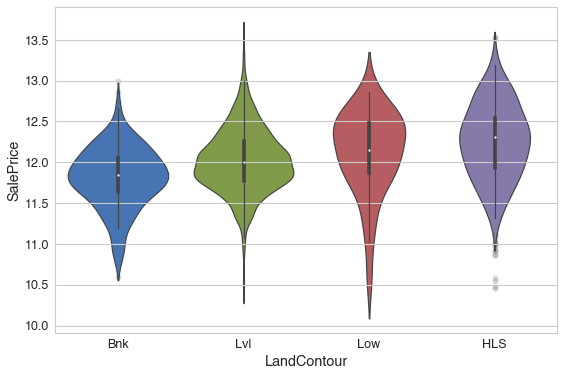

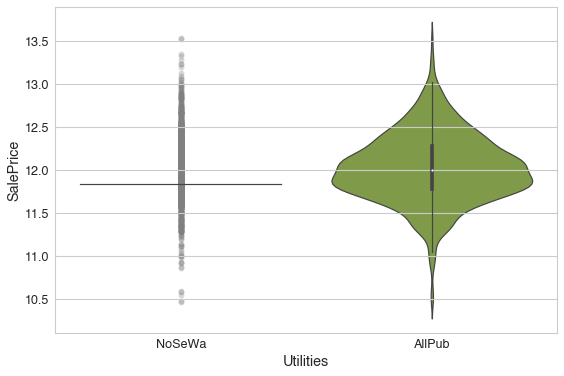

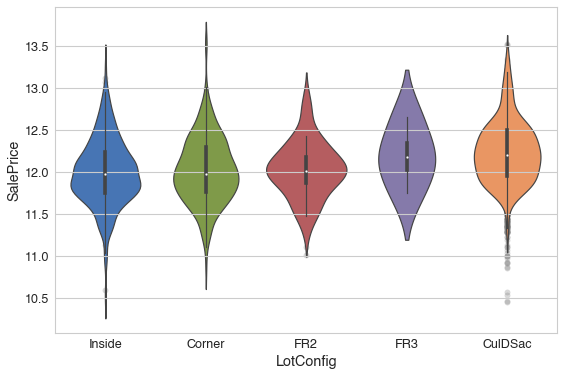

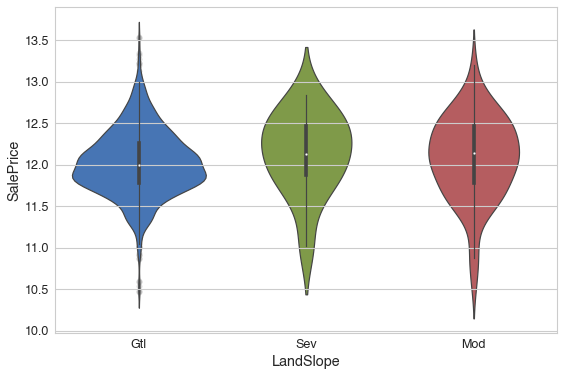

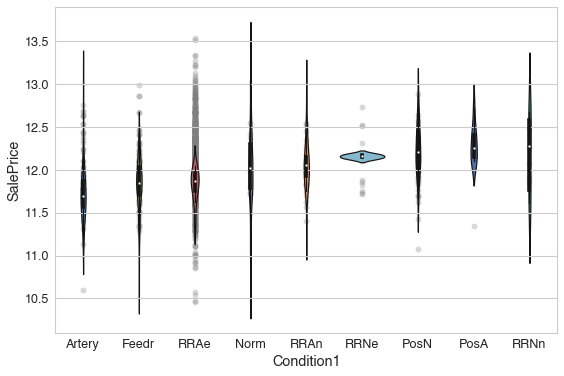

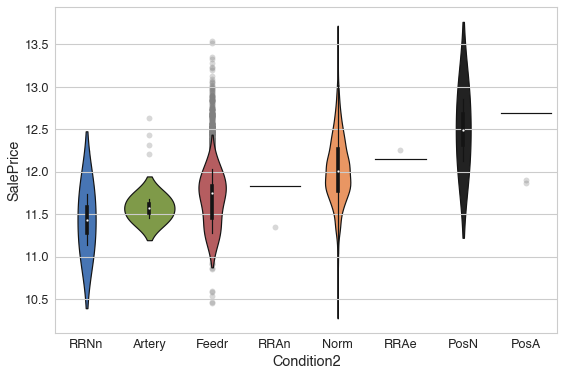

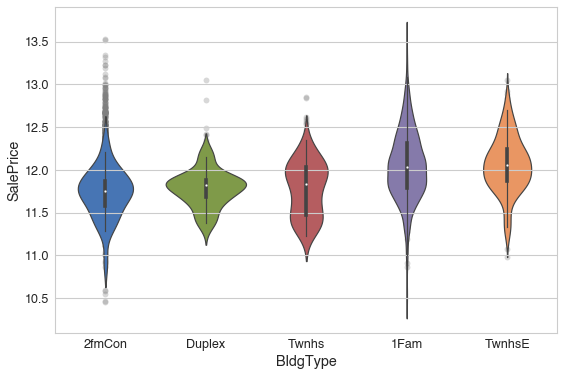

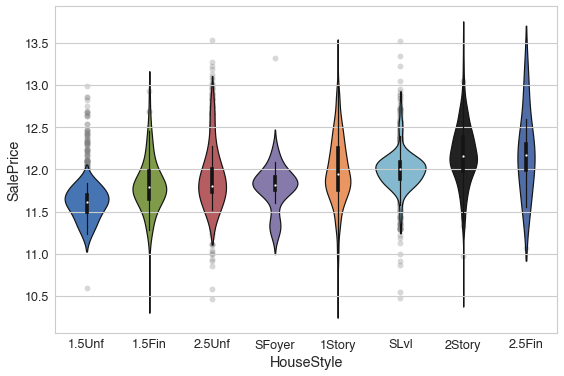

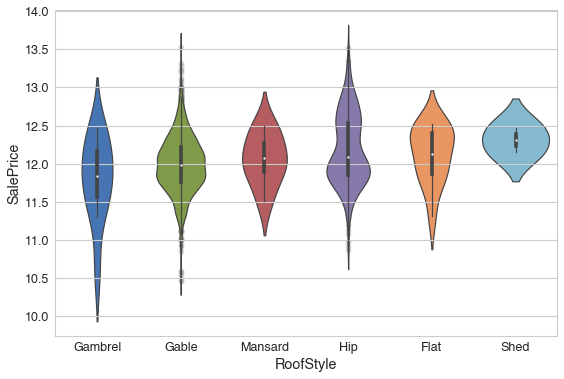

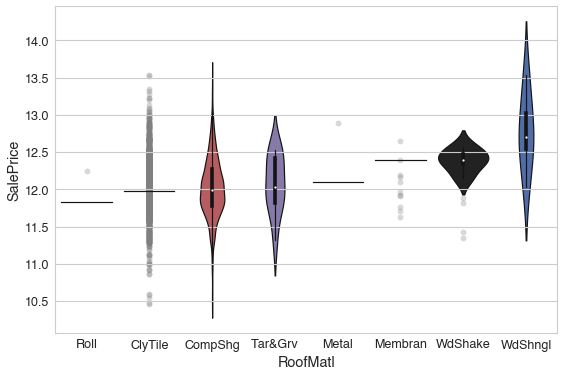

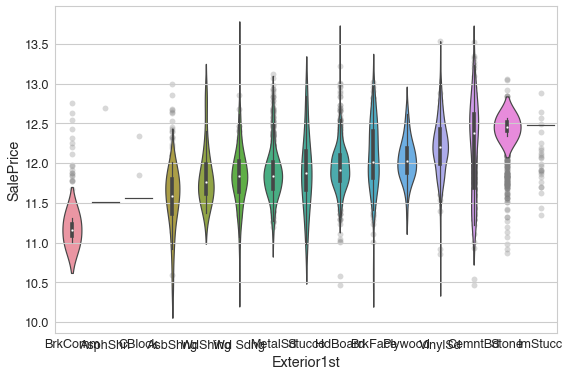

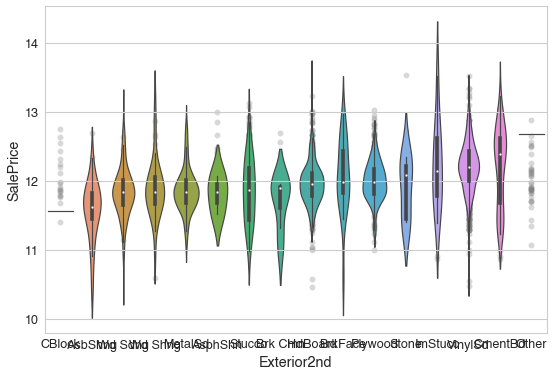

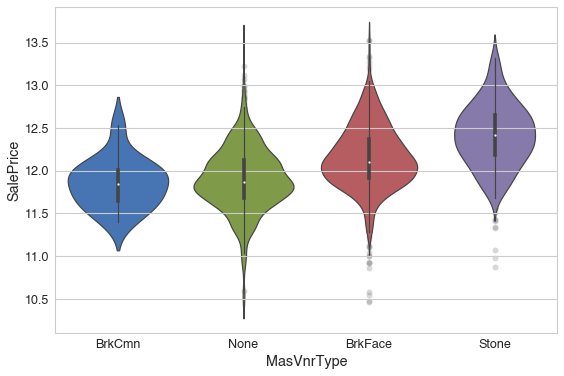

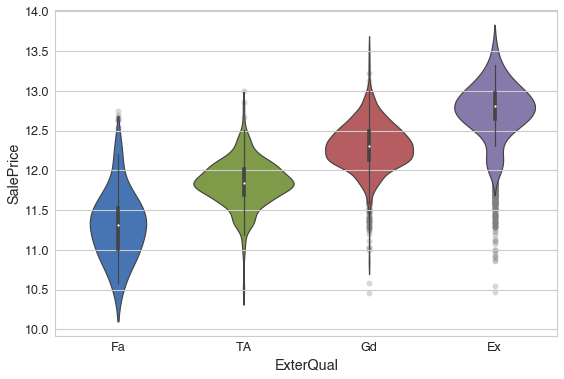

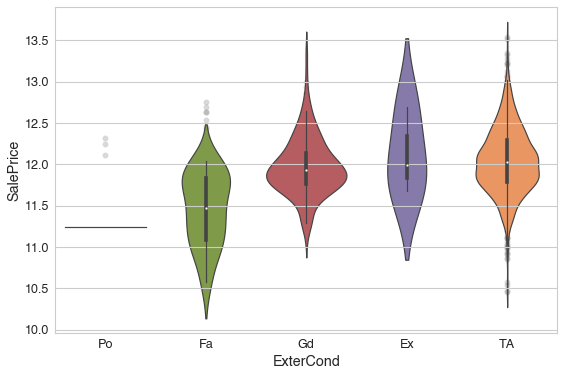

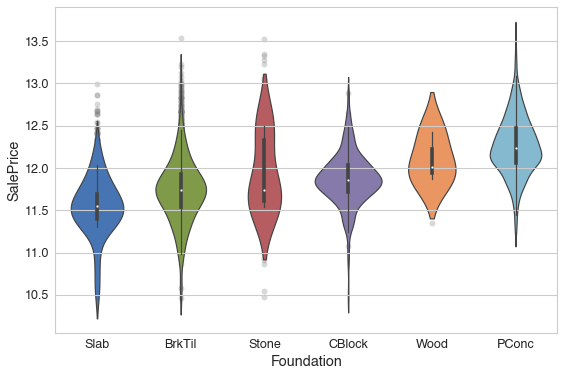

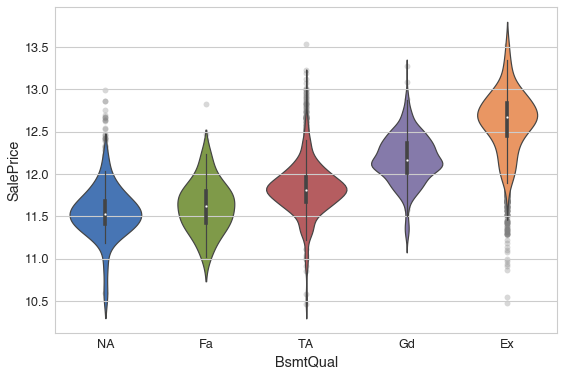

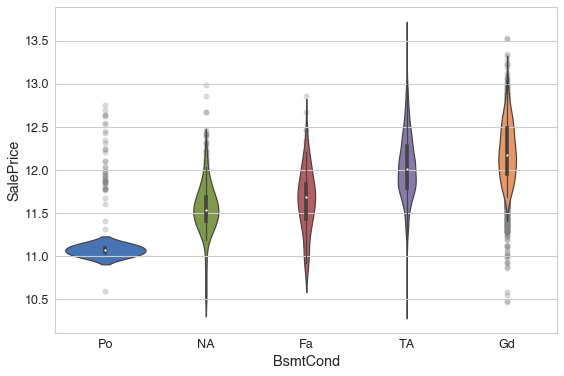

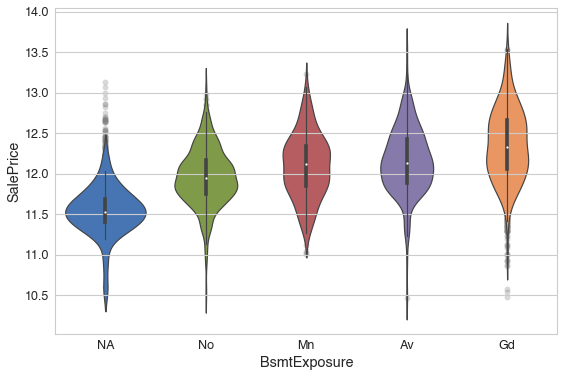

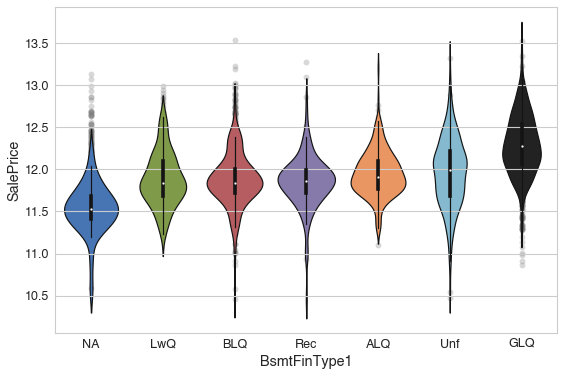

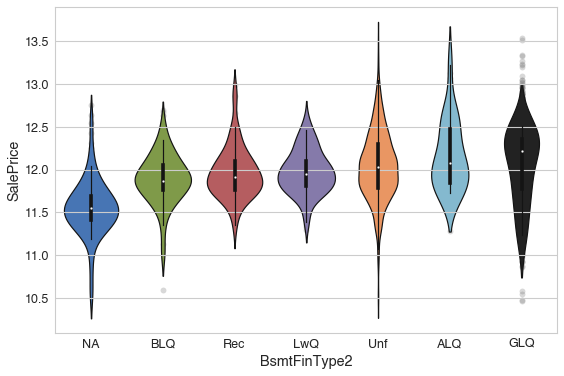

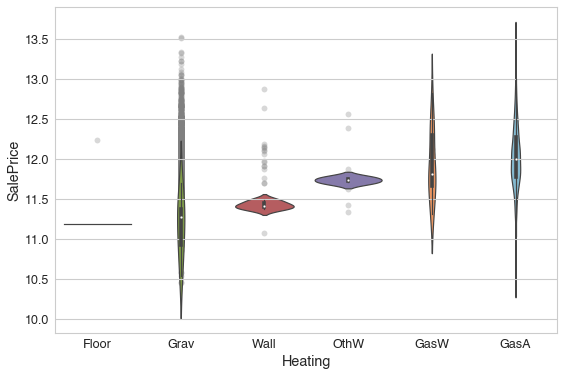

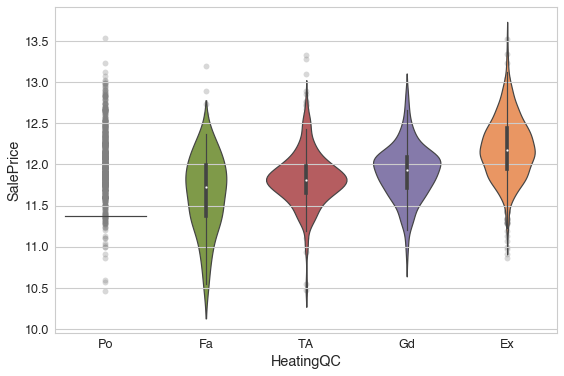

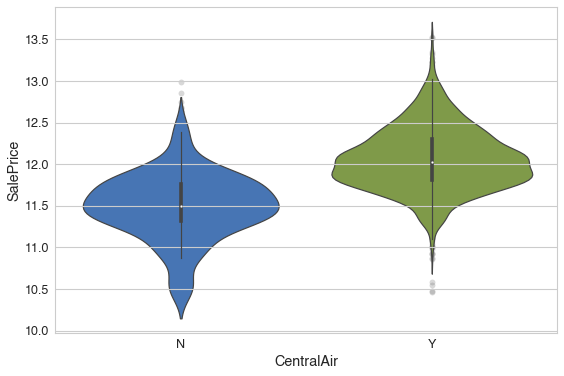

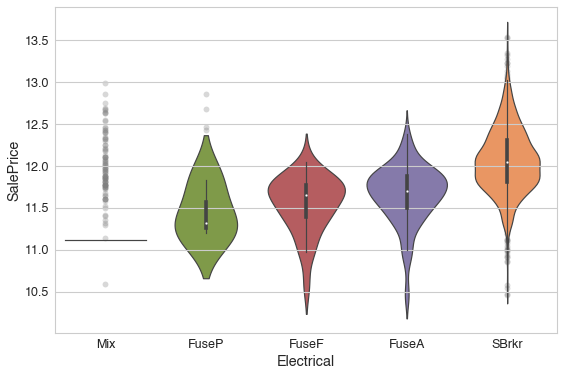

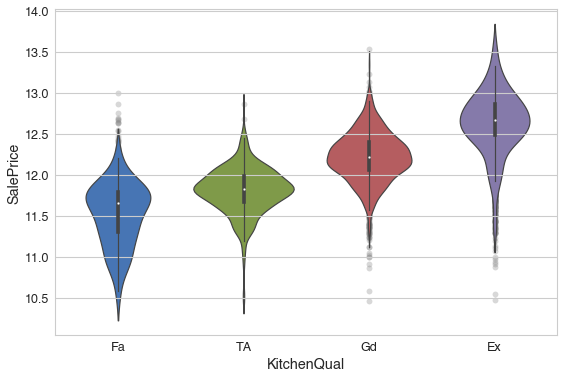

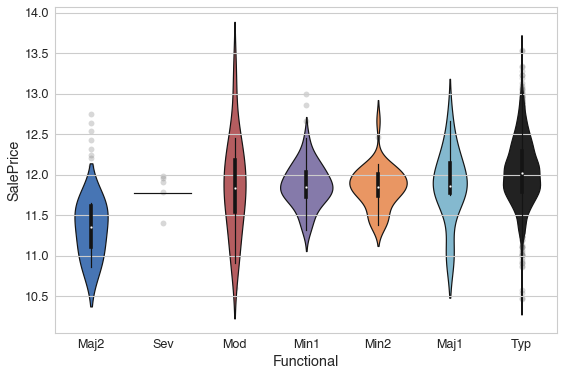

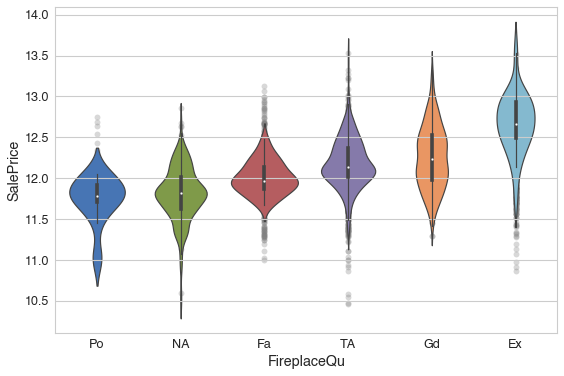

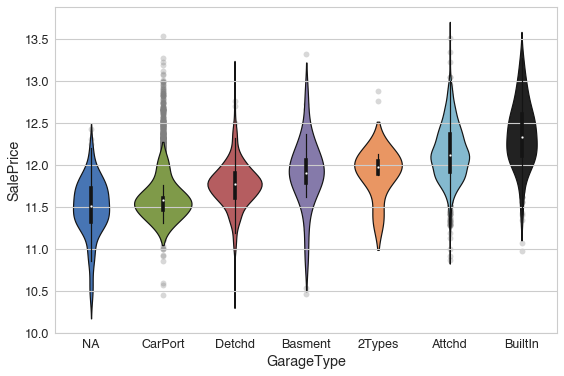

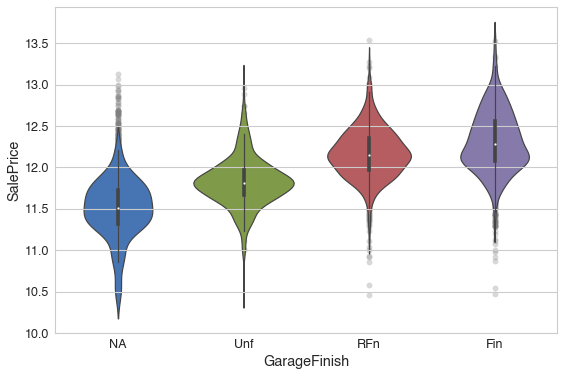

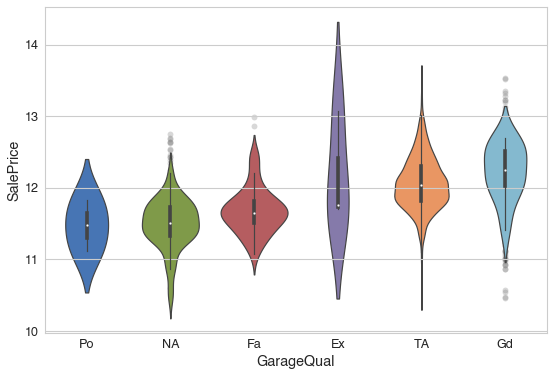

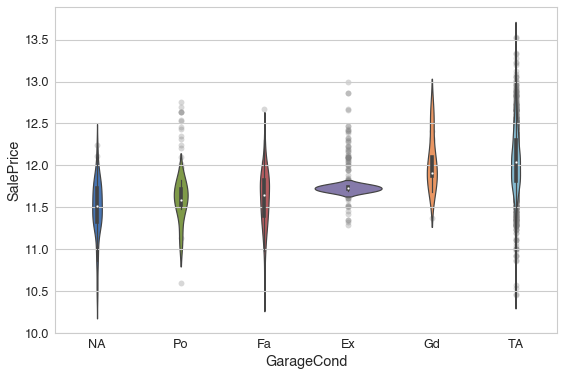

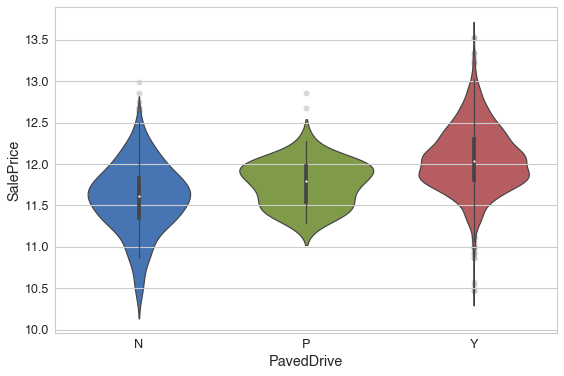

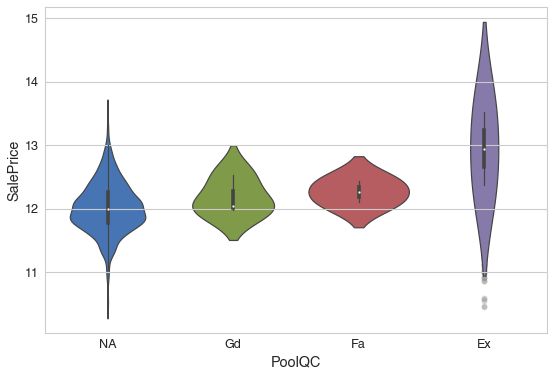

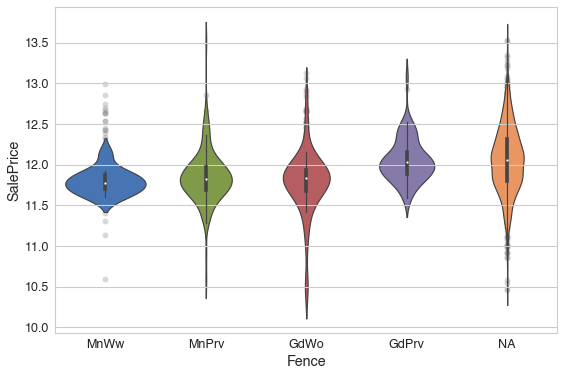

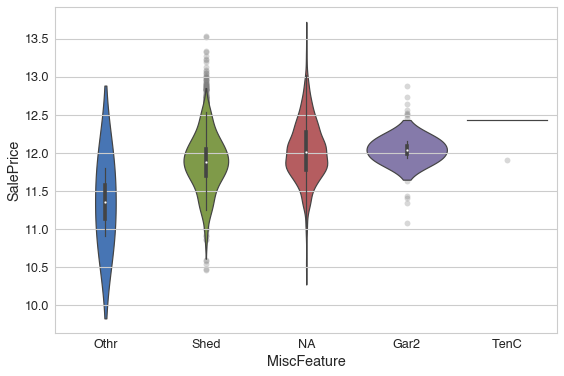

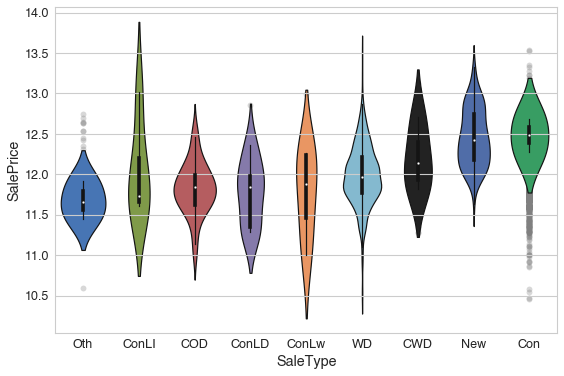

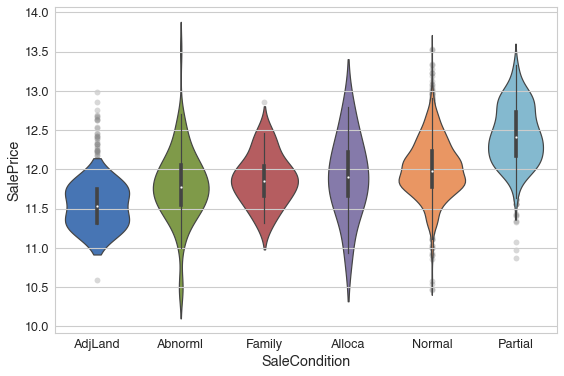

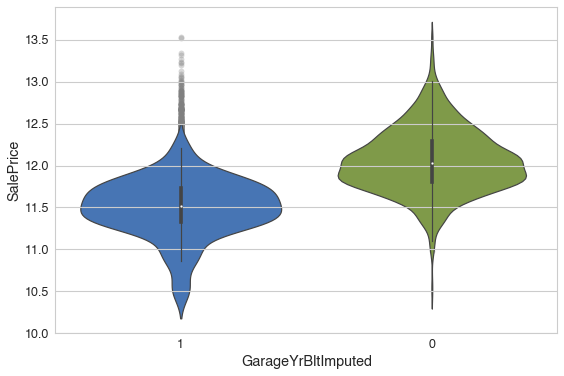

In [100]:
for i in df_c.columns[1:]:
    order = df_c.groupby(i)['SalePrice'].median().sort_values()
    plt.figure(figsize=(9, 6))
    plt.scatter(df_c[i].sort_values(),df_c['SalePrice'], alpha='0.3', color='grey', cmap='viridis')
    sns.violinplot(df_c[i].sort_values(),df_c['SalePrice'],order=order.index)

In [48]:
df_c_n = df.loc[:,['Neighborhood','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MiscFeature','SaleType','SaleCondition']]
for i in df_c_n.columns:
    df_c_n[i] = pd.factorize(df_c_n[i])[0]+1
df_n_s = np.log1p(df.loc[:,['OpenPorchSF','MasVnrArea','WoodDeckSF','BsmtFinSF1','2ndFlrSF','TotalBsmtSF']])
df_train = pd.concat([df.iloc[:,79:80], df_n_s, df_c_n], axis=1)

In [49]:
# Convert string to numeric and merge some category because of small number
#df_3_c['Electrical'] = df_3_c['Electrical'].apply(lambda x:0 if x=='FuseP' else 1 if x=='FuseF' else 2 if x=='FuseA' else 3 if x=='Mix' else 4)
#df_3_c['KitchenQual'] = df_3_c['KitchenQual'].apply(lambda x:0 if x=='Po' else 1 if x=='Fa' else 2 if x=='TA' else 3 if x=='Gd' else 4)
#df_3_c['FireplaceQu'] = df_3_c['FireplaceQu'].apply(lambda x:0 if x=='NA' else 1 if x=='Po' else 2 if x=='Fa' else 3 if x=='TA' else 4 if x=='Gd' else 5)
#df_3_c['Functional'] = df_3_c['Functional'].apply(lambda x:0 if x=='Sal' else 1 if x=='Sev' else 2 if x=='Maj1' or x=='Maj2' else 3 if x=='Mod' else 4 if x=='Min1' or x=='Min2' else 5)

list(map(lambda x: df_c[x].value_counts(), df_c.columns[1:]))

[NAmes      225
 CollgCr    150
 OldTown    113
 Edwards    100
 Somerst     86
 Gilbert     79
 NridgHt     77
 Sawyer      74
 NWAmes      73
 SawyerW     59
 BrkSide     58
 Crawfor     51
 Mitchel     49
 NoRidge     41
 Timber      38
 IDOTRR      37
 ClearCr     28
 StoneBr     25
 SWISU       25
 Blmngtn     17
 MeadowV     17
 BrDale      16
 Veenker     11
 NPkVill      9
 Blueste      2
 Name: Neighborhood, dtype: int64, 20     536
 60     299
 50     144
 120     87
 30      69
 160     63
 70      60
 80      58
 90      52
 190     30
 85      20
 75      16
 45      12
 180     10
 40       4
 Name: MSSubClass, dtype: int64, RL         1151
 RM          218
 FV           65
 RH           16
 C (all)      10
 Name: MSZoning, dtype: int64, Pave    1454
 Grvl       6
 Name: Street, dtype: int64, NA      1369
 Grvl      50
 Pave      41
 Name: Alley, dtype: int64, Reg    925
 IR1    484
 IR2     41
 IR3     10
 Name: LotShape, dtype: int64, Lvl    1311
 Bnk      63
 HLS      

In [50]:
df_3_c.groupby('FireplaceQu')['SalePrice'].agg(['min','max','mean','median','std']).sort_values('mean')

NameError: name 'df_3_c' is not defined

In [ ]:
#stats.chisquare(df_3_c.iloc[:,1:4],df_3_c.SalePrice)

In [ ]:
for i in df_c.columns:
    print(df_c[i].value_counts())

** SalesPrice - Neighborhood **
chi^2 : 16898.75578956907
p value : 1.364960102688296e-08
degree of freedom : 15888

** SalesPrice - MSZoning **
chi^2 : 3147.8911158183737
p value : 4.3483250606822396e-11
degree of freedom : 2648

** SalesPrice - Street **
chi^2 : 888.3129945096931
p value : 8.338870380464053e-09
degree of freedom : 662

** SalesPrice - LotShape **
chi^2 : 2446.2353573800365
p value : 4.724729155980402e-12
degree of freedom : 1986

** SalesPrice - LandContour **
chi^2 : 2072.335508433759
p value : 0.08674645041917711
degree of freedom : 1986

** SalesPrice - LotConfig **
chi^2 : 2771.9854545078742
p value : 0.045806211958033756
degree of freedom : 2648

** SalesPrice - LandSlope **
chi^2 : 1388.847891459522
p value : 0.10508638737793884
degree of freedom : 1324

** SalesPrice - Condition2 **
chi^2 : 4772.610202894631
p value : 0.07598640644469955
degree of freedom : 4634

** SalesPrice - MasVnrType **
chi^2 : 2293.470454143226
p value : 1.597523579519887e-06
degree of 

Text(0.5, 1.0, 'chi^2 value of categorical variables')

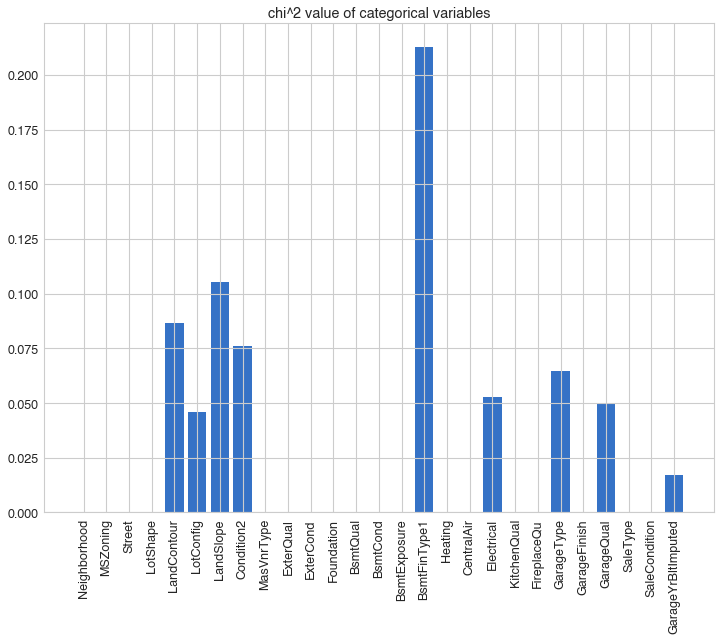

In [147]:
df_chi2 = pd.DataFrame(columns=['Feature','Value'])

for i in df_c.columns[1:]:
    X = df_c.SalePrice
    Y = df_c[i]
    chi2 = stats.chi2_contingency(pd.crosstab(Y,X))
    if chi2[1] < 0.5:        
        df_chi2 = df_chi2.append({'Feature':i,'Value':chi2[1]}, ignore_index=True)
        print('** SalesPrice - ' + str(i) + ' **')
        print('chi^2 : ' + str(chi2[0]))
        print('p value : ' + str(chi2[1]))
        print('degree of freedom : ' + str(chi2[2]))
        print('')
plt.figure(figsize=(12,9))
plt.bar(df_chi2.Feature, df_chi2.Value)
plt.xticks(rotation=90)
plt.title('chi^2 value of categorical variables')
#df_chi2

In [129]:
fs.chi2(df_c.iloc[:,1:].to_numpy(), df_c.SalePrice)
fs.SelectKBest(fs.chi2, k=2).fit_transform(df_c.iloc[:,1:].to_numpy(), df_c.SalePrice)

ValueError: could not convert string to float: 'CollgCr'

In [ ]:
def graph(formula, x_range, label=None):
    """
    Helper function for plotting cook's distance lines
    """
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')


def diagnostic_plots(X, y, model_fit=None):
  """
  Function to reproduce the 4 base plots of an OLS model in R.

  ---
  Inputs:

  X: A numpy array or pandas dataframe of the features to use in building the linear regression model

  y: A numpy array or pandas series/dataframe of the target variable of the linear regression model

  model_fit [optional]: a statsmodel.api.OLS model after regressing y on X. If not provided, will be
                        generated from X, y
  """

  if not model_fit:
      model_fit = sm.OLS(y, sm.add_constant(X)).fit()

  # create dataframe from X, y for easier plot handling
  dataframe = pd.concat([X, y], axis=1)

  # model values
  model_fitted_y = model_fit.fittedvalues
  # model residuals
  model_residuals = model_fit.resid
  # normalized residuals
  model_norm_residuals = model_fit.get_influence().resid_studentized_internal
  # absolute squared normalized residuals
  model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
  # absolute residuals
  model_abs_resid = np.abs(model_residuals)
  # leverage, from statsmodels internals
  model_leverage = model_fit.get_influence().hat_matrix_diag
  # cook's distance, from statsmodels internals
  model_cooks = model_fit.get_influence().cooks_distance[0]

  plot_lm_1 = plt.figure()
  plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                            lowess=True,
                            scatter_kws={'alpha': 0.5},
                            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

  plot_lm_1.axes[0].set_title('Residuals vs Fitted')
  plot_lm_1.axes[0].set_xlabel('Fitted values')
  plot_lm_1.axes[0].set_ylabel('Residuals');

  # annotations
  abs_resid = model_abs_resid.sort_values(ascending=False)
  abs_resid_top_3 = abs_resid[:3]
  for i in abs_resid_top_3.index:
      plot_lm_1.axes[0].annotate(i,
                                 xy=(model_fitted_y[i],
                                     model_residuals[i]));

  QQ = ProbPlot(model_norm_residuals)
  plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
  plot_lm_2.axes[0].set_title('Normal Q-Q')
  plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
  plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
  # annotations
  abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
  abs_norm_resid_top_3 = abs_norm_resid[:3]
  for r, i in enumerate(abs_norm_resid_top_3):
      plot_lm_2.axes[0].annotate(i,
                                 xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                     model_norm_residuals[i]));

  plot_lm_3 = plt.figure()
  plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
  sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
  plot_lm_3.axes[0].set_title('Scale-Location')
  plot_lm_3.axes[0].set_xlabel('Fitted values')
  plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

  # annotations
  abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
  abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
  for i in abs_norm_resid_top_3:
      plot_lm_3.axes[0].annotate(i,
                                 xy=(model_fitted_y[i],
                                     model_norm_residuals_abs_sqrt[i]));


  plot_lm_4 = plt.figure();
  plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
  sns.regplot(model_leverage, model_norm_residuals,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
  plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
  plot_lm_4.axes[0].set_ylim(-3, 5)
  plot_lm_4.axes[0].set_title('Residuals vs Leverage')
  plot_lm_4.axes[0].set_xlabel('Leverage')
  plot_lm_4.axes[0].set_ylabel('Standardized Residuals');

  # annotations
  leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
  for i in leverage_top_3:
      plot_lm_4.axes[0].annotate(i,
                                 xy=(model_leverage[i],
                                     model_norm_residuals[i]));

  p = len(model_fit.params) # number of model parameters
  graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
        np.linspace(0.001, max(model_leverage), 50),
        'Cook\'s distance') # 0.5 line
  graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
        np.linspace(0.001, max(model_leverage), 50)) # 1 line
  plot_lm_4.legend(loc='upper right');

In [ ]:
df_n

In [ ]:
df_o_scaled_log.shape

In [ ]:
df_o_scaled_log[['SalePrice']].shape

In [ ]:
diagnostic_plots(pd.DataFrame(df_o_scaled_log.iloc[:,1:]),pd.DataFrame(df_o_scaled_log[['SalePrice']]))

In [ ]:
df_o_scaled_log.columns

In [ ]:
df_train

In [ ]:
#X = df_o_scaled_log[['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea']]
#Y = df_o_scaled_log['SalePrice']
#X = df_n[['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']]
#Y = df_n['SalePrice']
X = df_train.iloc[:,1:]
Y = df_train.SalePrice

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=60)

In [ ]:
# apply model
from sklearn.ensemble import RandomForestRegressor

featureNum_set = list(range(2, X_train.shape[1]+1))

for featureNum_tmp in featureNum_set:
    RF_tmp = RandomForestRegressor(n_estimators = 1000, criterion = "mse", n_jobs = 5, oob_score = True, max_features = featureNum_tmp) 
    RF_tmp.fit(X_train, Y_train)
    preds = RF_tmp.predict(X_test)
    RMSE = np.mean((preds - Y_test)**2)**(1/2) # Ensemble 
    print(RMSE)
    print(featureNum_tmp)
    print(" ")

#RF = RandomForestClassifier(n_estimators = 500, criterion = "gini", n_jobs=1, oob_score = True)
RF = RandomForestRegressor(n_estimators = 1000, criterion = "mse", n_jobs = 1, oob_score = True)
RF.fit(X_train, Y_train)
print(RF.oob_score_)

random_divide = ms.KFold(n_splits=10)
scores = ms.cross_val_score(estimator=RF, X=X, y=Y, cv=random_divide)
print(scores)

preds = RF.predict(X_train)
RMSE = np.mean((preds - Y_train)**2)**(1/2) # Ensemble 
print(RMSE)

preds = RF.predict(X_test)
RMSE = np.mean((preds - Y_test)**2)**(1/2) # Ensemble 
print(RMSE)

print('training set accuracy : %.3f'%RF.score(X_train, Y_train))
print('test set accuracy : %.3f'%RF.score(X_test, Y_test))

df_tmp = pd.DataFrame({"x": list(preds), "y": list(Y_test)})
lm = sns.lmplot("x","y", data = df_tmp, fit_reg = False, height = 5)
axes = lm.axes
axes[0,0].set_ylim(0,50)
axes[0,0].set_xlim(0,50)


In [ ]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

#boxcox1p(df_n['LotFrontage'], boxcox_normmax(df_n['LotFrontage']+1))
#pd.Series(stats.boxcox(df_n['LotFrontage']))
stats.probplot(boxcox1p(df_n['LotFrontage'], boxcox_normmax(df_n['LotFrontage']+1)), dist="norm", plot=pylab)
pylab.show()

In [ ]:
#df[(df['OpenPorchSF']>0) | (df['EnclosedPorch']>0) | (df['3SsnPorch']>0) | (df['ScreenPorch']>0)]
df['porch'] = df.apply(lambda x: 1 if (x['OpenPorchSF']>0) | (x['EnclosedPorch']>0) | (x['3SsnPorch']>0) | (x['ScreenPorch']>0) else 0, axis=1)
df['porchArea'] = df.apply(lambda x: x['OpenPorchSF'] + x['EnclosedPorch'] + x['3SsnPorch'] + x['ScreenPorch'], axis=1)

In [ ]:
df.groupby('porch')['SalePrice'].agg(['mean'])

In [ ]:
plt.figure(figsize=(12,9))
sns.boxplot(df['porch'],df['SalePrice'])

In [ ]:
plt.figure(figsize=(12,9))
plt.hist(np.log1p(df['porchArea']))

In [ ]:
plt.figure(figsize=(12,9))
plt.scatter(np.log1p(df['porchArea']),df['SalePrice'])

In [ ]:
df['PoolQC_m'] = df.apply(lambda x:1 if x['PoolQC']=='Ex' else 0, axis=1)
df['SaleCondition_m'] = df.apply(lambda x:1 if x['SaleCondition']=='Partial' else 0, axis=1)
df['SaleType_m'] = df.apply(lambda x:1 if (x['SaleType']=='New') | (x['SaleType']=='Con') else 0, axis=1)
df['FireplaceQu_m'] = df.apply(lambda x:1 if x['FireplaceQu']=='Ex' else 0, axis=1)
df['KitchenQual_m'] = df.apply(lambda x:1 if x['KitchenQual']=='Ex' else 0, axis=1)
df['RoofMatl_m'] = df.apply(lambda x:1 if x['RoofMatl']=='WdShngl' else 0, axis=1)
df['Condition2_m'] = df.apply(lambda x:1 if x['Condition2']=='PosN' else 0, axis=1)
df['ExterQual_m'] = df.apply(lambda x:1 if x['ExterQual']=='Ex' else 0, axis=1)
df['BsmtQual_m'] = df.apply(lambda x:1 if x['BsmtQual']=='Ex' else 0, axis=1)
df['Heating_m'] = df.apply(lambda x:1 if (x['Heating']=='GasA') | (x['Heating']=='GasW') else 0, axis=1)
df['HeatingQC_m'] = df.apply(lambda x:1 if x['HeatingQC']=='Ex' else 0, axis=1)
df['porch_m'] = df.apply(lambda x: 1 if (x['OpenPorchSF']>0) | (x['EnclosedPorch']>0) | (x['3SsnPorch']>0) | (x['ScreenPorch']>0) else 0, axis=1)

In [ ]:
tmp = df.loc[:,['SalePrice','PoolQC_m','SaleCondition_m','SaleType_m','FireplaceQu_m','KitchenQual_m','RoofMatl_m','Condition2_m','ExterQual_m','BsmtQual_m','Heating_m','HeatingQC_m','porch_m']]

In [ ]:
for i in tmp.columns[1:]:
    X = tmp.SalePrice
    Y = tmp[i]
    chi2 = stats.chi2_contingency(pd.crosstab(Y,X))
    if chi2[1] < 0.05:
        print('** SalesPrice - ' + str(i) + ' **')
        print('chi^2 : ' + str(chi2[0]))
        print('p value : ' + str(chi2[1]))
        print('degree of freedom : ' + str(chi2[2]))
        print('')

In [ ]:
df.columns

In [ ]:
df.apply(lambda x : str(x['YrSold'])+'0'+str(x['MoSold']) if x['MoSold']<10 else str(x['YrSold'])+str(x['MoSold']), axis=1)

In [ ]:
df['YrSold'] = df['YrSold'].astype(str)

In [ ]:
plt.figure(figsize=(12,9))
plt.scatter(df['YrSold'],df['SalePrice'])
sns.boxplot(df['YrSold'],df['SalePrice'])

In [ ]:
df['LowQualFinSF'] = df.apply(lambda x:1 if x['LowQualFinSF']>0 else 0, axis=1)
plt.figure(figsize=(12,9))
plt.scatter(df['LowQualFinSF'],df['SalePrice'])
sns.boxplot(df['LowQualFinSF'],df['SalePrice'])

In [ ]:
df_n.values

In [ ]:
from statsmodels.tools.tools import add_constant
t = add_constant(df_n)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
t = add_constant(df_n)
list(zip(df_n.columns,[variance_inflation_factor(t.values, i) for i in range(t.shape[1])]))

In [ ]:
list(vif)